
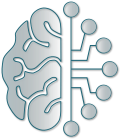

**Start at:** Tuesday 23 July 2024, 09:50:05  
**Hostname:** insa-12842 (Linux)

<p style="text-align: center"><img width="800px" src="./config/svg/pyPhysChemBanner.svg" style="margin-left:auto; margin-right:auto"/></p>

In [1]:
import os
import sys

cwd0 = './config/'
sys.path.append(cwd0)

import visualID_Eng as vID
from visualID_Eng import color, fg, bg, hl
vID.init(cwd0)
import tools4pyPhysChem as t4pPC

#cancel the "last show-up" behaviour of Jupyter notebooks
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Autoencoders

## Introduction

<div class="intro">

A classic result in cognitive psychology is that experts have an excellent memory for meaningful material taken from their domain of expertise, **even when this material is presented only briefly**. 
As proposed by Herbert A. Simon and William G. Chase in their 1973 paper titled "Perception in Chess", expertise in chess is acquired by learning, through practice and study, a large number of "**chunks**", which are units of both perception and meaning. Chunks consist of constellations of pieces occurring often together in masters’ games. Experts’ superiority with meaningful material (game positions in chess) is explained by their ability to **rapidly memorize positions on a chess game** by **identifying patterns present on the board**, and retrieve chunks from their long-term memory (LTM).

<img width="40%" src="./ML-Figures/Chess/Chess.svg" style="display:block; margin-left:auto; margin-right:auto" id="Fischer"/> 
<br>

The connection between Chase and Simon's work on **chunking in chess** and **autoencoders** lies in the concept of learning **meaningful (*compact*) representations**. In both cases, the goal is to extract and represent important features or patterns from complex data.

In the context of chess, the process of chunking involves recognizing meaningful patterns or configurations of pieces on the board. Similarly, **an autoencoder learns to extract the most important features from the input data** (in this case, a lower-dimensional representation) **that are sufficient to reconstruct the original input**. This process can be thought of as finding an efficient **compact representation**, the **latent representation**, that captures the essential information in the data.

</div>
<br>
<div class="intro">

An autoencoder is a type of artificial neural network used for **unsupervised learning**. It is designed to learn efficient representations or codings of input data, typically for the purpose of dimensionality reduction, feature extraction, or generative modeling. 

Autoencoder, by design, reduces data dimensions by learning how to ignore the noise in the data.
    
<img width="30%" src="./DS4B-Slides/pngs/ZooNN/AEwithLegend.svg" style="display:block; margin-left:auto; margin-right:auto" id="AE"/> 

Autoencoders consists of three main parts:

1- **Encoder**: In which the model learns how to reduce the input dimensions and compress the input data into an encoded representation.

2- **Bottleneck** or **Latent space**: which is the layer that contains the compressed representation of the input data. This is the lowest possible dimensions of the input data.

3- **Decoder**: In which the model learns how to reconstruct the data from the encoded representation to be as close to the original input as possible.

Another important component is the **Reconstruction Loss**: this is the method that measures how well the decoder is performing and how close the output is to the original input

When we use autoencoders, we actually do not care about the output itself, but rather we care about the vector constructed in the middle (the **latent vector**). This vector is important because it is a representation of the input image and with this representation, we could potentially do several tasks like reconstructing the original image. We can think of the latent vector as a code for an image, which is where the terms encode/decode come from. 


</div>

## General functions and libraries importation

In [2]:
import sklearn
import tensorflow as tf
import keras
import numpy as np
import sklearn

import pandas as pd
from IPython.display import display

import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

tf.config.experimental.list_physical_devices()
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")

from pathlib import Path

IMAGES_PATH = Path() / "ML-SavedFigures/autoencoders"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

MODELS_PATH = Path() / "ML-SavedModels/autoencoders"
MODELS_PATH.mkdir(parents=True, exist_ok=True)

def get_var_name(arg):
    return [k for k,v in globals().items() if v == arg]

def save_fig(fig_id, IMAGES_PATH=".", tight_layout=True, fig_extension="png", resolution=300):
    '''
    saves a figure to a given subfolder, that will be created if it does not exist
    input:
        - fig_id = name of the figure, without an extension
        - IMAGES_PATH = pathway to the folder. Default: "."
        - tight_layout = boolean. Automatically adjusts subplot params so that the subplot(s) fits in to the figure area. Default: True
        - fig_extension = image type. Default: png
        - resolution = resolution of the figure, in dpi. Default: 300
    '''
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    return

def saveModel(model, model_id, MODELS_PATH=".", model_extension="keras"):
    '''
    saves a model to a given subfolder, that will be created if it does not exist
    input:
        - model = keras model
        - model_id = name of the model file, without an extension
        - MODELS_PATH = pathway to the folder. Default: "."
        - model_extension = model type. Default: keras
    '''
    path = MODELS_PATH / f"{model_id}.{model_extension}"
    model.save(path)
    return

def saveDataFrame(df, df_id, MODELS_PATH=".", df_extension="xlsx"):
    
    path = MODELS_PATH / f"{df_id}.{df_extension}"
    print(f"Saving {path}")
    if df_extension == 'xlsx':
        df.to_excel(path, engine='xlsxwriter') 
    elif df_extension == 'pickle':
        df.to_pickle(path)
    return

def loadDataFrame(df_id, MODELS_PATH=".", df_extension="xlsx"):

    import pandas as pd
    path = MODELS_PATH / f"{df_id}.{df_extension}"
    print(f"Loading {path}")
    if df_extension == 'xlsx':
        return pd.read_excel(path, index_col=0) 
    elif df_extension == 'pickle':
        return pd.read_pickle(path)

def plotModel(model, model_id, MODELS_PATH=".", fig_extension="png", resolution=300,
              show_shapes=True, show_layer_names=True, show_layer_activations=True):
    '''
    saves a model plot to a given subfolder, that will be created if it does not exist
    input:
        - model = keras model
        - model_id = name of the model file, without an extension
        - MODELS_PATH = pathway to the folder. Default: "."
        - model_extension = model type. Default: png
    '''
    from tensorflow.keras.utils import plot_model
    from matplotlib.pyplot import plot
    path = MODELS_PATH / f"{model_id}.{fig_extension}"
    plot_model(model, to_file=path, dpi=resolution, show_shapes=show_shapes, 
               show_layer_names=show_layer_names, show_layer_activations=show_layer_activations)
    img = plt.imread(path)
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    return

def plotEpochs(history,metrics):
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    # c'est pratique d'utiliser un dataframe et les fonctions de tracé associées
    df=pd.DataFrame(data=history.history)

    nEpoch = df.shape[0]
    print(nEpoch)
    
    plt.rcParams["figure.figsize"] = (8,4)
    # on va d'abord tracer les courbes de la fonction qui a été minimisée au cours de l'apprentissage
    figLOSS=df.plot(y=["loss","val_loss"],linestyle='-', marker='o',fontsize=14)
    figLOSS.set_xlabel('epoch',fontdict={'fontsize':16})
    figLOSS.set_ylabel('loss',fontdict={'fontsize':16})
    yMin = np.min(df[["loss","val_loss"]].iloc[nEpoch//3:nEpoch,:].to_numpy())
    yMax = np.max(df[["loss","val_loss"]].iloc[nEpoch//3:nEpoch,:].to_numpy())
    yMin = round(yMin-0.05,1)
    yMax = round(yMax+0.05,1)
    print(yMin,yMax)
    figLOSS.set_ylim([yMin,yMax])
    figLOSS.legend(loc='upper right', shadow=True, fontsize='x-large')
    plt.show()

    for i in range(len(metrics)):
        ErrTraining = metrics[i]
        ErrVal = "val_" + ErrTraining
        figACC=df.plot(y=[ErrTraining,ErrVal],linestyle='-', marker='o',fontsize=14)
        figACC.set_xlabel('epoch',fontdict={'fontsize':16})
        figACC.set_ylabel(ErrTraining,fontdict={'fontsize':16})
        yMin = np.min(df[[ErrTraining,ErrVal]].iloc[nEpoch//3:nEpoch,:].to_numpy())
        yMax = np.max(df[[ErrTraining,ErrVal]].iloc[nEpoch//3:nEpoch,:].to_numpy())
        yMin = round(yMin-0.05,1)
        yMax = round(yMax+0.05,1)
        print(yMin,yMax)
        figACC.set_ylim([yMin,yMax])
        figACC.legend(loc='lower right', shadow=True, fontsize='x-large')
        plt.show()

2024-07-23 09:50:08.041706: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-23 09:50:08.044070: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-23 09:50:08.077050: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-23 09:50:08.101959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 09:50:08.135826: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

No GPU was detected. Neural nets can be very slow without a GPU.


## Application to the Fashion MNIST dataset

<div class="intro">

Example adapted from Aurélien Géron's [book](https://www.oreilly.com/library/view/hands-on-machine-learning/9781098125967/) and [tutorials](https://github.com/ageron/handson-ml3)
<img width="20%" src="./ML-Figures/ImagesDivers/AGeron-3rd edition.jpg" style="display:block; margin-left:auto; margin-right:auto" id="AE"/> 

</div>

### Useful functions

In [136]:
def plotFashionToGrid(X, y, fashion_names, nrows=5, ncols=8, startFrom=0, yActual=None, saveFig = False, IMAGES_PATH=".",save_imgs=False, fig_extension="png"):
    '''
    plots nrows x ncols images with plt.imshow(), with their label as title
    input:
        - X = array with nimg b&w images coded as (npix,npix). Size = (nimg, npix, npix)  
        - y = 1D array made of nimg integers = class number
        - fashion_names = array with the corresponding class names
        - nrows, ncols = dimension of the plot grid (nrows x ncols must be <= nimg)
        - startFrom = index of the first image that will be shown
        - yActual = only useful when evaluating a prediction. It will contain the
          actual integer labels of the images
          In this case, y must be set to the value predicted by the model
          When a prediction is wrong, the label will be shown in red
        - saveFig = saves the figure to IMAGES_PATH
        - IMAGES_PATH = pathway to save images. Default: "."
    '''
    from matplotlib import pyplot as plt
    from PIL import Image

    plt.rc('font', size=14)
    plt.rc('axes', labelsize=14, titlesize=12)
    plt.rc('legend', fontsize=14)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.figure(figsize=(ncols * 1.2, nrows * 1.2))
    nimg = nrows * ncols
    if nimg > len(y) - startFrom:
        print(f"Sample size = {len(y)}. Cannot plot {nrows} x {ncols} = {nimg} images, with startFrom set as {startFrom}")
        print(f"startFrom automatically setup to {len(y) - nimg}")
        startFrom = len(y) - nimg
    for row in range(nrows):
        for col in range(ncols):
            index = ncols * row + col + startFrom
            plt.subplot(nrows, ncols, index + 1 - startFrom) # the third argument represents the index of the subplot that will be used
            plt.imshow(X[index], cmap="binary", interpolation="nearest",vmin=0.0, vmax=1.0) # the data X is resampled to the pixel size of the image on the figure canvas, using the "nearest" interpolation method
            plt.axis('off')
            colorTitle = 'black'
            if yActual is not None and yActual[index] != y[index]:
                colorTitle='red'
            plt.title(fashion_names[y[index]],color=colorTitle)
            if save_imgs:
                file = IMAGES_PATH + f"img{index:06d}.{fig_extension}" 
                I8 = (((X[index] - X[index].min()) / (X[index].max() - X[index].min())) * 255.9).astype(np.uint8)
                img = Image.fromarray(I8)
                img.save(file)

    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    if (saveFig):
        save_fig(IMAGES_PATH,"fashion_mnist_grid",fig_extension=fig_extension)
    plt.show()
    return

def compareReconstructionsWithOriginalImages(model, imgDataset, nimg=5, startFrom=0, saveFig = False, IMAGES_PATH="."):

    selectedImg = imgDataset[startFrom:startFrom+nimg]
    reconstrucedImg = model.predict(selectedImg)
    
    plt.rc('font', size=14)
    plt.rc('axes', labelsize=14, titlesize=12)
    plt.rc('legend', fontsize=14)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.figure(figsize=(nimg*1.5, 2*1.5)) #1 row for actual images, 1 row for reconstructed images
    if nimg > imgDataset.shape[0] - startFrom:
        print(f"Dataset size = {imgDataset.shape[0]}. Cannot plot {nimg} images, with startFrom set as {startFrom}")
        print(f"startFrom automatically setup to {imgDataset.shape[0] - nimg}")
        startFrom = imgDataset.shape[0] - nimg
    for img_index in range(nimg):
        plt.subplot(2, nimg, img_index+1) # the third argument represents the index of the subplot that will be used
        plt.imshow(selectedImg[img_index], cmap='binary', interpolation="nearest",vmin=0.0, vmax=1.0) # the data X is resampled to the pixel size of the image on the figure canvas, using the "nearest" interpolation method
        plt.axis('off')
        plt.subplot(2, nimg, nimg+img_index+1) # the third argument represents the index of the subplot that will be used
        plt.imshow(reconstrucedImg[img_index], cmap='binary', interpolation="nearest",vmin=0.0, vmax=1.0) # the data X is resampled to the pixel size of the image on the figure canvas, using the "nearest" interpolation method
        plt.axis('off')
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    if (saveFig):
        save_fig(IMAGES_PATH,"fashion_mnist_autoencoder")
    plt.show()
    return

def ShowLatentSpaceRepresentation(encoder, decoder, ae, imgDataset, img_index):
    img = imgDataset[img_index].reshape(1,imgDataset.shape[1],imgDataset.shape[2])
    LatentSpaceRepresentation = encoder.predict(img)
    Reconstructed_img = decoder.predict(LatentSpaceRepresentation)
    print(Reconstructed_img.shape)
    plt.rc('font', size=14)
    plt.rc('axes', labelsize=14, titlesize=12)
    plt.rc('legend', fontsize=14)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.figure(figsize=(24, 2))
    plt.subplots(1, 3, gridspec_kw={"width_ratios": [1, 2, 1]})
    plt.subplot(1, 3, 1) 
    plt.imshow(imgDataset[img_index], cmap='binary', interpolation="nearest",vmin=0.0, vmax=1.0)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(LatentSpaceRepresentation, cmap='binary', interpolation="nearest")
    plt.yticks([])
    plt.subplot(1, 3, 3) 
    plt.imshow(Reconstructed_img.reshape(28,28), cmap='binary', interpolation="nearest",vmin=0.0, vmax=1.0) 
    plt.axis('off')
    plt.show()
    return LatentSpaceRepresentation, Reconstructed_img

### Read the MNIST data

Size of images = W: 28 pixels x H: 28 pixels = 784 pixels


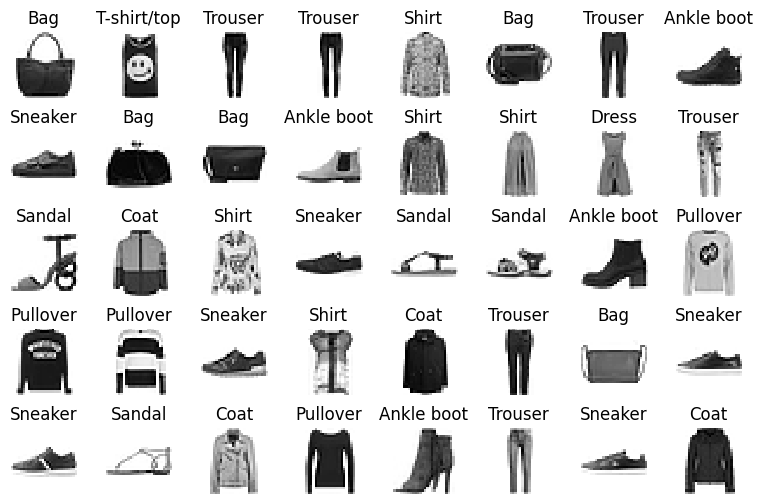

 0: T-shirt/top
 1: Trouser
 2: Pullover
 3: Dress
 4: Coat
 5: Sandal
 6: Shirt
 7: Sneaker
 8: Bag
 9: Ankle boot


(55000, 28, 28)

(55000,)

(5000, 28, 28)

(5000,)

(10000, 28, 28)

(10000,)

In [137]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist

imgW = X_train_full[0].shape[1]
imgH = X_train_full[0].shape[0]
print(f"Size of images = W: {imgW} pixels x H: {imgH} pixels = {imgW*imgH} pixels")

fashion_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
nclass = len(fashion_names)

X_train_full = X_train_full/255.0
X_test = X_test/255.0

t4pPC.centerTitle("Sample of the fashion items")
plotFashionToGrid(X_train_full, y_train_full, fashion_names, nrows=5, ncols=8, startFrom=100, IMAGES_PATH="./ML-Figures/FashionMNIST/IMGS/", save_imgs=True)

t4pPC.centerTitle("Fashion names")
for i, f in enumerate(fashion_names):
    print(f"{i:2d}: {f}")

X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
t4pPC.centerTitle("Training set")
X_train.shape
y_train.shape
t4pPC.centerTitle("Validation set")
X_valid.shape
y_valid.shape
t4pPC.centerTitle("Test set")
X_test.shape
y_test.shape



### Stacked autoencoders

<div id="CompilationOfTheModel"></div>

#### Creation and compilation of the model

/home/romuald/Python3/ML/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │        81,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,328 (317.69 KB)

 Trainable params: 81,328 (317.69 KB)

 Non-trainable params: 0 (0.00 B)

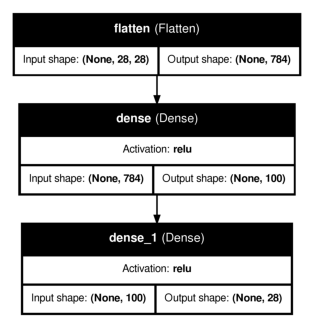

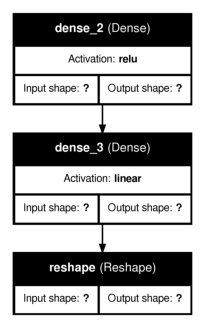

In [138]:
tf.keras.backend.clear_session()

tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[imgH,imgW]),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28, activation="relu"),
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(imgW * imgH),
    tf.keras.layers.Reshape([imgH, imgW])
])
stacked_aeModel = tf.keras.Sequential([stacked_encoder, stacked_decoder])

t4pPC.centerTitle("Summary of the model")
stacked_encoder.build()
stacked_decoder.build()
stacked_aeModel.build()
stacked_aeModel.summary()

t4pPC.centerTitle("Plot models")
plotModel(stacked_encoder, "StackedEncoder", MODELS_PATH=MODELS_PATH)
print()
plotModel(stacked_decoder, "StackedDecoder", MODELS_PATH=MODELS_PATH)


In [139]:
stacked_aeModel.compile(loss="mse", optimizer="nadam")
print(X_train.shape)

(55000, 28, 28)


#### Training

In [140]:
history_ae = stacked_aeModel.fit(X_train,
                                 X_train,
                                 epochs=20,
                                 batch_size=50,
                                 validation_data=(X_valid, X_valid)
                                )

Epoch 1/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0385 - val_loss: 0.0189
Epoch 2/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0181 - val_loss: 0.0171
Epoch 3/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0167 - val_loss: 0.0163
Epoch 4/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0160 - val_loss: 0.0158
Epoch 5/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0156 - val_loss: 0.0155
Epoch 6/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0153 - val_loss: 0.0153
Epoch 7/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0151 - val_loss: 0.0151
Epoch 8/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0149 - val_loss: 0.0150
Epoch 9/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0148 - val_loss: 0.0148
Epoch 10/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0146 - val_loss: 0.0147
Epoch 11/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0145 - val_loss: 0.0146
Epoch 12/20
1100/1100 ━━━━━━━━

#### Save the models

In [141]:
from varname import nameof
file = MODELS_PATH / f"{nameof(stacked_aeModel)}.keras"
stacked_aeModel.save(file)

file = MODELS_PATH / f"{nameof(stacked_encoder)}.keras"
stacked_encoder.save(file)

file = MODELS_PATH / f"{nameof(stacked_decoder)}.keras"
stacked_decoder.save(file)

#### Jump to this section if you do not want to train the models again

<div class="rqT" title="warning">

Don't forget to <a href="#CompilationOfTheModel">first create and compile the models (autoencoder, but also encoder and decoder)</a>
</div>

In [142]:
from varname import nameof
file = MODELS_PATH / f"{nameof(stacked_aeModel)}.keras"
stacked_aeModel = keras.models.load_model(file)

file = MODELS_PATH / f"{nameof(stacked_encoder)}.keras"
stacked_encoder = keras.models.load_model(file)

file = MODELS_PATH / f"{nameof(stacked_decoder)}.keras"
stacked_decoder = keras.models.load_model(file)

#### Visualizing the Reconstructions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


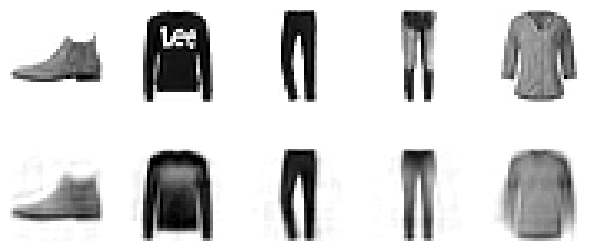

In [143]:
compareReconstructionsWithOriginalImages(stacked_aeModel,X_test)


<div class="rq">

Reconstructed images look blurry, but don't forget that original images were compressed down to 28 numbers instead of 28 $\times$ 28 = 784
</div>

#### Playing in the latent space

##### Compression/Uncompression of one image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
(1, 28, 28)


<Figure size 2400x200 with 0 Axes>

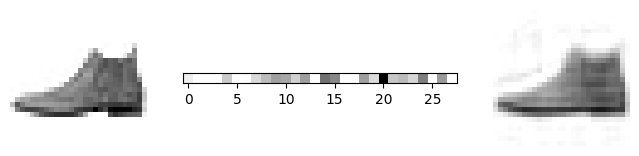

In [144]:
lsr, rimg = ShowLatentSpaceRepresentation(stacked_encoder,stacked_decoder, stacked_aeModel, X_test,0)

##### Normalize the latent space info

[[0.34566483 0.         0.         0.         1.0979388  0.
  0.05245529 0.7880676  1.3691843  1.9643421  1.8197063  0.9472747
  1.9890419  0.         2.927749   2.45262    0.         0.
  1.9693038  0.73649293 5.2228703  1.1793338  1.3935599  0.85029876
  2.6403756  0.         2.0704927  0.        ]]


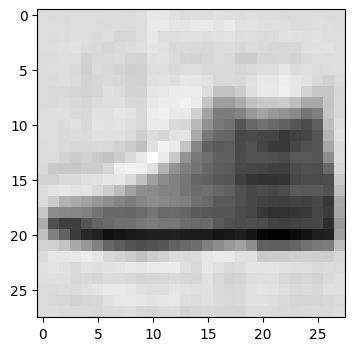

(<matplotlib.image.AxesImage at 0x7f580027a250>, None)

[[0.06618293 0.         0.         0.         0.2102175  0.
  0.01004338 0.15088783 0.2621517  0.37610394 0.34841117 0.18137051
  0.3808331  0.         0.5605632  0.46959236 0.         0.
  0.37705395 0.14101306 1.         0.22580186 0.2668188  0.16280296
  0.5055411  0.         0.39642814 0.        ]]
(1, 28)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


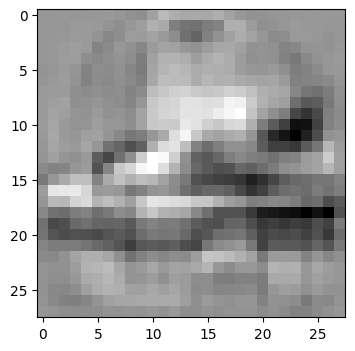

(<matplotlib.image.AxesImage at 0x7f58001ff490>, None)

In [145]:
print(lsr)
plt.imshow(rimg.reshape(28,28), cmap=plt.cm.binary, interpolation="nearest"), plt.show()
lsrN = (lsr - lsr.min()) / (lsr.max()- lsr.min())
print(lsrN)
print(lsrN.shape)
rimgN = stacked_decoder.predict(lsrN)
plt.imshow(rimgN.reshape(28,28), cmap=plt.cm.binary, interpolation="nearest"), plt.show()

##### Make a random latent space code

28
[[1.2788536  0.05002151 0.55005864 0.44642148 1.47294243 1.35339897
  1.78435914 0.17387767 0.84384364 0.05959444 0.43727595 1.01071058
  0.05307194 0.3976753  1.29976888 1.08988296 0.44088124 1.17853137
  1.61886091 0.01299752 1.6116385  1.39627879 0.68050103 0.310959
  1.91442614 0.67318909 0.18549169 0.19343275]]
(1, 28)


([], [])

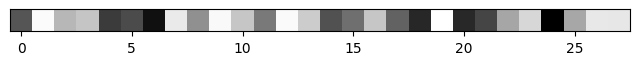

In [146]:
import random
import numpy as np
random.seed(42)
rndlsr = [random.uniform(0.,2.) for i in range(28)]
print(len(rndlsr))
rndlsr=np.array(rndlsr)
rndlsr = rndlsr.reshape((1,-1))
print(rndlsr)
print(rndlsr.shape)
plt.imshow(rndlsr, cmap=plt.cm.binary, interpolation="nearest")
plt.yticks([])
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


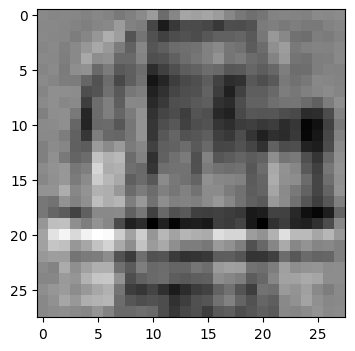

In [147]:
rndrimg = stacked_decoder.predict(rndlsr)
plt.imshow(rndrimg.reshape(28,28), cmap=plt.cm.binary, interpolation="nearest")
plt.show()

##### Switch on each neuron of the latent space

<Figure size 1259.84x649.606 with 0 Axes>

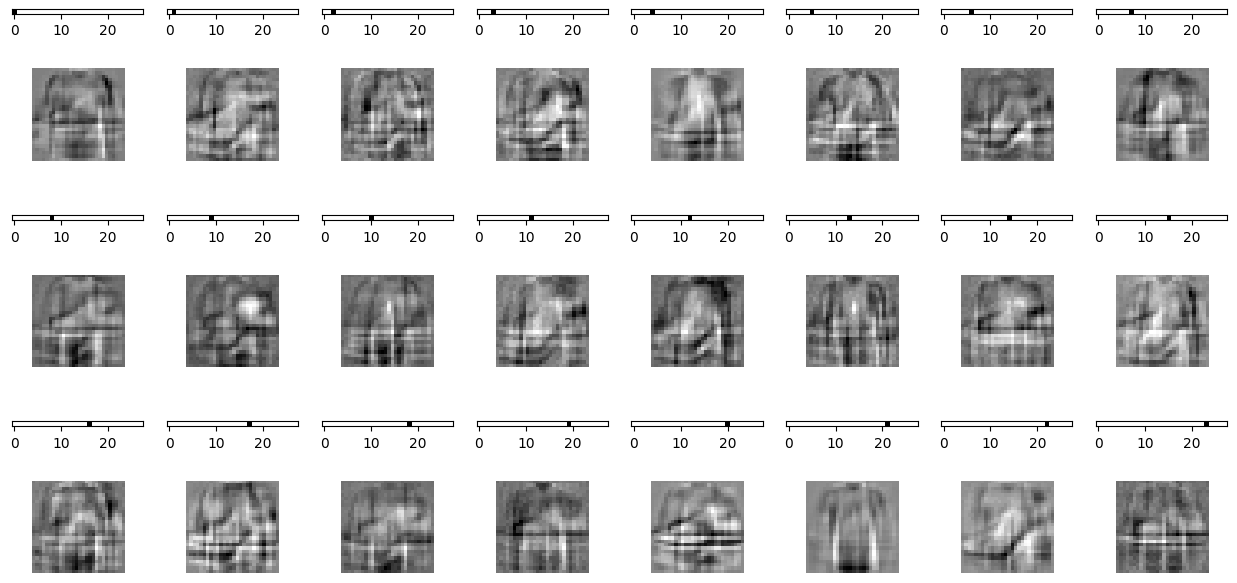

In [148]:
cm = 1/2.54
ncols = 8
nrows = 3
plt.figure(figsize=(ncols*4*cm, nrows*5.5*cm))
indexLSR = 0
indexIMG = 0
index = 0
for row in range(nrows):
    for col in range(ncols):
        index += 1
        indexLSR = (row)*2*ncols + col + 1
        indexIMG = indexLSR + ncols
        lsrPixByPix = np.zeros_like(rndlsr)
        lsrPixByPix[0,index-1] = 1.0
        imgPixByPix = stacked_decoder.predict(lsrPixByPix,verbose=0)
        _ = plt.subplot(nrows*2, ncols, indexLSR)
        _ = plt.imshow(lsrPixByPix, cmap=plt.cm.binary, interpolation="nearest")
        _ = plt.yticks([])
        _ = plt.subplot(nrows*2, ncols, indexIMG)
        _ = plt.imshow(imgPixByPix.reshape(28,28), cmap=plt.cm.binary, interpolation="nearest")
        _ = plt.axis("off")
plt.tight_layout()
plt.show()


##### Encode/Decode free-hand drawings

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
(1, 28, 28)


<Figure size 2400x200 with 0 Axes>

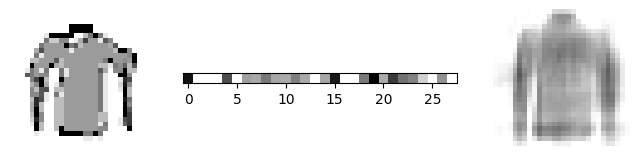

In [149]:
fh_img = plt.imread("./ML-Figures/FashionMNIST/FreehandDrawing_Shirt_28x28.png")
fh_img = fh_img.reshape(1,fh_img.shape[0],fh_img.shape[1]); plt.show()
lsr, rimg = ShowLatentSpaceRepresentation(stacked_encoder,stacked_decoder, stacked_aeModel, fh_img,0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
(1, 28, 28)


<Figure size 2400x200 with 0 Axes>

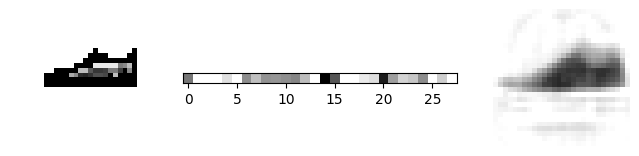

In [150]:
fh_img = plt.imread("./ML-Figures/FashionMNIST/FreehandDrawing_Sneaker_28x28.png")
fh_img = fh_img.reshape(1,fh_img.shape[0],fh_img.shape[1]); plt.show()
lsr, rimg = ShowLatentSpaceRepresentation(stacked_encoder,stacked_decoder, stacked_aeModel, fh_img,0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
(1, 28, 28)


<Figure size 2400x200 with 0 Axes>

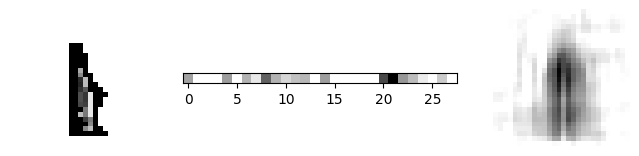

In [151]:
fh_img = plt.imread("./ML-Figures/FashionMNIST/FreehandDrawing_SneakerVertical_28x28.png")
fh_img = fh_img.reshape(1,fh_img.shape[0],fh_img.shape[1]); plt.show()
lsr, rimg = ShowLatentSpaceRepresentation(stacked_encoder,stacked_decoder, stacked_aeModel, fh_img,0)

##### Reconstruct an image with defects?

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
(1, 28, 28)


<Figure size 2400x200 with 0 Axes>

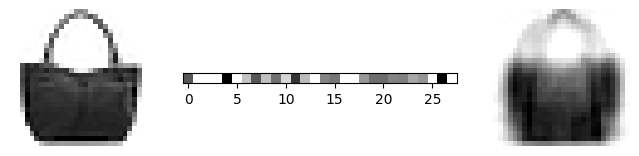

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
(1, 28, 28)


<Figure size 2400x200 with 0 Axes>

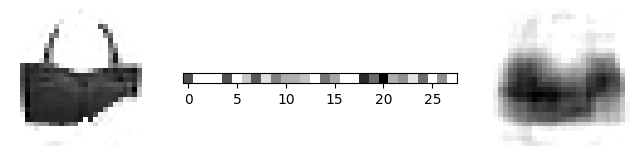

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
(1, 28, 28)


<Figure size 2400x200 with 0 Axes>

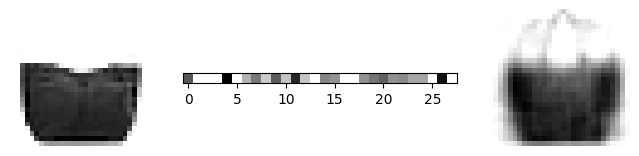

In [152]:
t4pPC.centerTitle('Original image')
fh_img = plt.imread("./ML-Figures/FashionMNIST/img000100.png")
fh_img = fh_img.reshape(1,fh_img.shape[0],fh_img.shape[1]); plt.show()
lsr, rimg = ShowLatentSpaceRepresentation(stacked_encoder,stacked_decoder, stacked_aeModel, fh_img,0)

t4pPC.centerTitle('Image with defect. 1')
fh_img = plt.imread("./ML-Figures/FashionMNIST/img000100Defect1.png")
fh_img = fh_img.reshape(1,fh_img.shape[0],fh_img.shape[1]); plt.show()
lsr, rimg = ShowLatentSpaceRepresentation(stacked_encoder,stacked_decoder, stacked_aeModel, fh_img,0)

t4pPC.centerTitle('Image with defect. 2')
fh_img = plt.imread("./ML-Figures/FashionMNIST/img000100Defect2.png")
fh_img = fh_img.reshape(1,fh_img.shape[0],fh_img.shape[1]); plt.show()
lsr, rimg = ShowLatentSpaceRepresentation(stacked_encoder,stacked_decoder, stacked_aeModel, fh_img,0)


#### Visualization of the latent space

In [154]:
from sklearn.manifold import TSNE
X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)
print(X_valid_2D)

print(y_valid)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
[[ 39.09224    19.328354 ]
 [ 54.806408   -7.303551 ]
 [  8.164881   38.173336 ]
 ...
 [-18.679783   57.646683 ]
 [ -1.3427747  14.804181 ]
 [-21.646278  -22.127558 ]]
[0 8 0 ... 3 0 5]


0 T-shirt/top (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)
1 Trouser (1.0, 0.4980392156862745, 0.054901960784313725, 1.0)
2 Pullover (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0)
3 Dress (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0)
4 Coat (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0)
5 Sandal (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0)
6 Shirt (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0)
7 Sneaker (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0)
8 Bag (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0)
9 Ankle boot (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0)


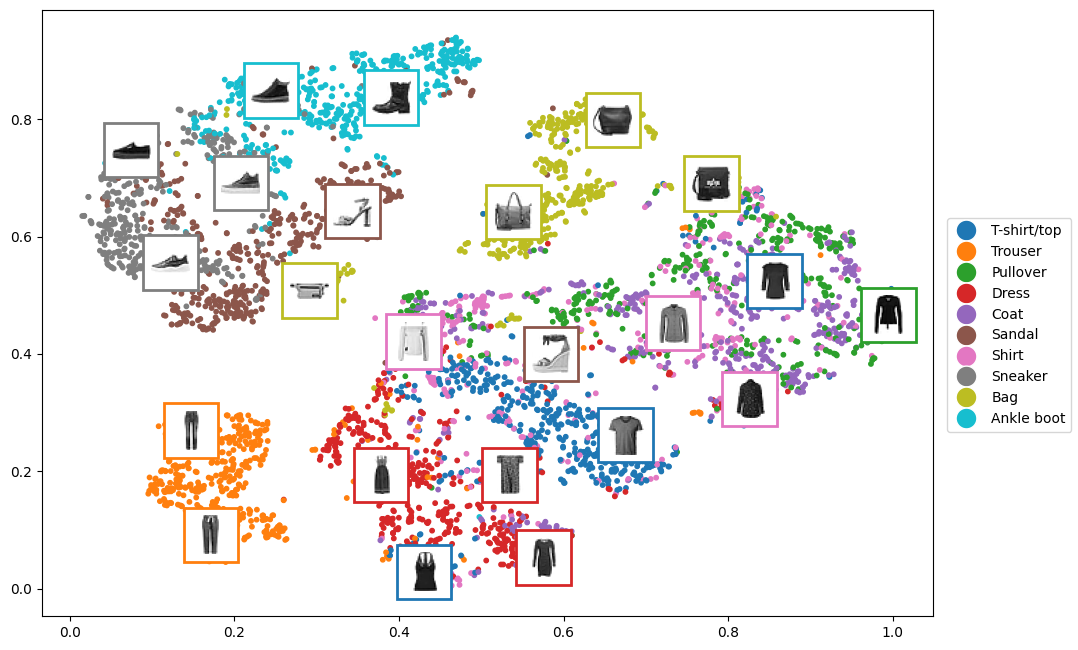

In [31]:
import matplotlib as mpl
from matplotlib.lines import Line2D
cmap = plt.cm.tab10
t4pPC.centerTitle('Fashion indexes, names and colors in the selected color map scheme')
LegendElements = []
for i, f in enumerate(fashion_names):
    print(i, f, cmap(i))
    LegendElement = Line2D([0], [0], marker='o', color='w', label=f, markerfacecolor=cmap(i), markersize=15)
    LegendElements.append(LegendElement)

t4pPC.centerTitle('TSNE scheme')
Z = X_valid_2D.copy()
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
cm = 1/2.54
fig, ax = plt.subplots(figsize=(30*cm, 20*cm))
scatter = ax.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap="tab10")
fig.legend(handles=LegendElements, loc='center right',fontsize=10)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        _ = ax.add_artist(imagebox)
        
fig.subplots_adjust(right=0.88)
plt.show()

## Autoencoders applied to SMILES 

**co-authors: Nans Bernard & Romuald Poteau**

### Useful functions

#### Atom-level tokenization class

<div class="intro">
    
Tokenization, in the realm of **Natural Language Processing** (NLP) and machine learning, refers to the process of **converting a sequence of text into smaller parts**, known as **tokens**. These tokens can be as small as characters or as long as words. The primary reason this process matters is that it helps machines understand human language by breaking it down into bite-sized pieces, which are easier to analyze.
</div>
    
<div class="intro">

The goal of `tokenization` class and of its functions is to convert a smiles into a list of tokens, in order to read it better as a sequence of letters. For example:
- smiles = `C[C@@H](CN1c2ccccc2Sc2ccc(C#N)cc21)C[NH+](C)C`
- tokenized smiles= `'C', '[C@@H]', '(', 'C', 'C', '(', 'C', '(', 'N', ')', '=', 'O', ')', '(', 'c', '1', 'c', 'c', 'c', 'c', 'c', '1', ')', 'c', '1', 'c', 'c', 'c', 'c', 'c', '1', ')', '[NH+]', '(', 'C', ')', 'C'`
</div>

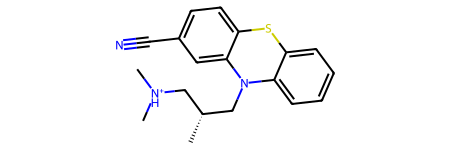

In [38]:
from rdkit import Chem
Chem.MolFromSmiles('C[C@@H](CN1c2ccccc2Sc2ccc(C#N)cc21)C[NH+](C)C')

In [39]:
import re
from rdkit.Chem import PandasTools,Draw
from IPython.display import display
import pickle
# Fix seed for reproducible results
SEED = 22

def canonicalize_smiles(smiles):
    '''This function takes a non-canonical SMILES and returns the canonical version
    
    Args: 
        -smiles: str, non-canonical SMILES of a molecule
    
    Out:
        - canonical_smiles: str, canonical SMILES of the molecule
    '''
    
    mol = Chem.MolFromSmiles(smiles) #create a mol object from input smiles.
    can = Chem.MolToSmiles(mol) #convert the previous mol object to SMILES. By default, RDKit canonicalizes the SMILES when applying this MolToSmiles() function

    return can

class tokenization:
    def __init__(self,
                 smilesFile,separator='\t',
                 smilesHeader = 'Smiles',
                 reduceNumberOfMolTo=None,
                 debug=False,
                ):
        self.df = pd.read_csv(smilesFile,sep=separator)
        if reduceNumberOfMolTo is not None:
            self.df=self.df.sample(n=reduceNumberOfMolTo)
            msg = f', reduced to {reduceNumberOfMolTo} samples'
        else:
            msg = ''
        t4pPC.centerTitle(f"Reading the {smilesFile} file"+msg)
        smilesHeaderCan = "Canonicalized " + smilesHeader
        self.df[smilesHeaderCan] = self.df[smilesHeader].apply(canonicalize_smiles)
        display(self.df)
        self.smiles2AtomLevelTokens(smilesHeader, debug)
        self.atomicLevelTokens2Pixels()
        PandasTools.AddMoleculeColumnToFrame(self.df, smilesCol=smilesHeaderCan)
        PandasTools.RenderImagesInAllDataFrames(True)
        display(self.df)
        
    def atomLevelTokenization(self, data, with_begin_and_end=True):        # fonction to tokenize
        """Tokenizes a SMILES string."""
        REGEXPS = {                                           # group of characters that we want to tokenize
                "brackets": re.compile(r"(\[[^\]]*\])"),
                "2_ring_nums": re.compile(r"(%\d{2})"),
                # "2char_symbols": re.compile(r"(Cl|Br)")
                "2char_symbols": re.compile(r"(He|Li|Be|Ne|Na|Mg|Al|Si|Cl|Br|At)")
            }
        
        REGEXP_ORDER = ["brackets", "2_ring_nums", "2char_symbols"]
    
        def split_by(data, regexps):
            if not regexps:
                return list(data)
            regexp = REGEXPS[regexps[0]]
            splitted = regexp.split(data)
            tokens = []
            for i, split in enumerate(splitted):
                if i % 2 == 0:
                    tokens += split_by(split, regexps[1:])
                else:
                    tokens.append(split)
            return tokens
    
        tokens = split_by(data, REGEXP_ORDER)
        
        if with_begin_and_end:
            tokens = ["^"] + tokens + ["$"]
        return tokens
    
    def smiles2AtomLevelTokens(self, NameOfSmilesColumn,debug=False):
        smiles2TokensList=[]
        if debug: t4pPC.centertxt("Tokens for each SMILES",size=14,weight='bold',bgc="#82c3c3",fgc="black")
        for i,smiles in enumerate(self.df[NameOfSmilesColumn]):
            smiles_tokeniser=self.atomLevelTokenization(smiles, with_begin_and_end=False)
            smiles2TokensList=smiles2TokensList+[smiles_tokeniser]
            if debug: print(f"{smiles}, {smiles2TokensList[i]}")
        # Dictionary
        t4pPC.centertxt("Smiles to atom-level tokens",size=14,weight='bold',bgc="#82c3c3",fgc="black")
        counter = {}
        
        longestWord = ""
        maxLength = 0
        
        # Cycle through each sentence in the list
        for sentence in smiles2TokensList:
            # Cycle through each character in the list tokken
            for charactr in sentence:
                # If the character is already in the dictionary, increment the count
                if charactr in counter:
                    counter[charactr] += 1
                # Otherwise, add the character to the dictionary with a count of 1
                else:
                    counter[charactr] = 1
        
            if len(sentence) > maxLength:
                maxLength = len(sentence)
                longestWord = sentence
                nUniqueTokens = len(np.unique(np.array(sentence)))
            
        dictionary = list(counter.keys())
        
    
        if debug:
            for charactr, nombre in counter.items():
                print(f"there is/are {nombre:4d} '{charactr}'...")
            print("... in the database")
            print("------------------------")
            print(f"Total = {len(counter)} tokens")
            print("------------------------")
        
        print("dictionary :", dictionary)
        print()
        print(f"the longuest word is made of {maxLength} tokens, built on {nUniqueTokens} unique tokens:{fg.BLUE}{longestWord}{hl.OFF}")
        self.df['smiles2Tokens'] = smiles2TokensList
        self.dictionary = dictionary
        self.longestWord = longestWord
        
    def atomicLevelTokens2Pixels(self):
        '''
        Transforms tokenized SMILES into a token-based pixelized picture 
        '''
        t4pPC.centertxt("Tokenized smiles transformed into pixelized images",size=14,weight='bold',bgc="#82c3c3",fgc="black")
        dictLength=len(self.dictionary)
        index_dict = {charactr: idx for idx, charactr in enumerate(self.dictionary)}
        pixels = []
        for token in self.df["smiles2Tokens"]:
            pixelI = np.zeros((len(self.longestWord), dictLength), dtype=int)
            for i, charactr in enumerate(token):
                if charactr in index_dict:
                    pixelI[i, index_dict[charactr]] = 1
            pixels.append(np.array(pixelI))
        self.df['pixels'] = pixels
        self.tokenSize=(len(self.longestWord),len(self.dictionary))

    def plot1pixelizedSmile(self,imgIndex,smilesHeader='Smiles',printMsg=False):
        smilesHeaderCan = "Canonicalized " + smilesHeader
        if printMsg:
            t4pPC.centertxt(f"{self.df[smilesHeaderCan].iloc[imgIndex]}",size=14,weight='bold',bgc="#82c3c3",fgc="black")
            print(f"tokenized smile = {self.df['smiles2Tokens'].iloc[imgIndex]}")
            display(self.df['ROMol'].iloc[imgIndex])
        cm2i = 1/2.54
        img = self.df['pixels'].iloc[imgIndex]
        _ = plt.figure(figsize=(0.4*cm2i*len(self.dictionary),0.4*cm2i*len(self.longestWord)))
        _ = plt.imshow(img, cmap='binary', interpolation="nearest",vmin=0.0, vmax=1.0) # the data X is resampled to the pixel size of the image on the figure canvas, using the "nearest" interpolation method
        _ = plt.axis('on')
        xpos = np.r_[:len(self.dictionary)]
        ypos = np.r_[:len(self.df["smiles2Tokens"].iloc[imgIndex])]
        _ = plt.xticks(xpos, self.dictionary, rotation=270, size = 9)
        _ = plt.yticks(ypos, self.df["smiles2Tokens"].iloc[imgIndex], rotation=0,size = 9)
        _ = plt.show()
        
    def pickle(self,fileWithPathway):
        with open(fileWithPathway, 'wb') as f:
            pickle.dump(self, f, pickle.HIGHEST_PROTOCOL)
        
    @staticmethod
    def unpickle(fileWithPathway):
        with open(fileWithPathway, 'rb') as f:
            return pickle.load(f)

#### Plot functions

In [40]:
def smiles_to_image(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return Draw.MolToImage(mol)

def normalizeImage(img,threshold=0.3):
    imgmax = np.max(img)
    img = img/imgmax
    img[img<threshold] = 0
    img[img>=threshold] = 1.0
    return img

def normalizeImage2(img,threshold=0.2):
    """
    each line must have at most one pixel switched on, unless no pixel value on a line is beyond the threshold
    """
    imgmax = np.max(img)
    img = img/imgmax
    print("shape = ",img.shape)
    for irow in range(img.shape[1]):
        row = img[0,irow,:]
        row2 = np.zeros_like(row)
        if np.max(row) >= threshold:
            row2[np.where(row==np.max(row))] = 1
        img[0,irow,:] = row2
    return img
    
def compareReconstructionsWithOriginalTokens(dftoken, encoderModel, edModel, index, imgDataset, smilesList, indexMol, saveFig = False, IMAGES_PATH="."):
    
    from scipy import ndimage
    cm2i = 1/2.54
    plt.rc('font', size=12)
    plt.rc('axes', labelsize=10, titlesize=12)
    plt.rc('legend', fontsize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.figure(figsize=((4*0.4*cm2i*len(dftoken.dictionary),0.4*cm2i*len(dftoken.longestWord)))) # 1 col for 2D image
                                    # 1 col for actual images
                                    # 1 col for latent space representation,
                                    # 1 col for reconstructed images
    if indexMol > imgDataset.shape[0]-1:
        print(f"Dataset size = {imgDataset.shape[0]}. Cannot plot {indexMol}th image")
        print(f"Plot automatically setup to {imgDataset.shape[0]-1}")
        indexMol = imgDataset.shape[0]-1

    print(f"Index of the molecule = {index[indexMol]}")
    selectedImg = imgDataset[indexMol]
    print(selectedImg.shape)
    selectedImg4prediction = selectedImg.reshape(1,len(dftoken.longestWord),len(dftoken.dictionary))
    # print(selectedImg4prediction.shape)
    reconstrucedImg = edModel.predict(selectedImg4prediction)
    # print(reconstrucedImg)
    reconstrucedImg = normalizeImage2(reconstrucedImg)
    # print(np.max(reconstrucedImg))
    reconstrucedImg = reconstrucedImg.reshape(len(dftoken.longestWord),len(dftoken.dictionary))
    LatentSpaceRepresentation = encoderModel.predict(selectedImg4prediction)
    selectedSmiles = smilesList[indexMol]
    # display(dftoken.df["smiles2Tokens"])
    # print(smilesList)
    # for i,s in enumerate(smilesList): 
    #     print(i," = ",s)
    #     print(dftoken.df["smiles2Tokens"].loc[index[i]])
    #     plt.imshow(smiles_to_image(s))
    #     plt.show()
    plt.subplot(1, 4, 1)
    mol_img = smiles_to_image(selectedSmiles)
    plt.imshow(mol_img)
    plt.axis('off')

    plt.subplot(1, 4, 2) # the third argument represents the index of the subplot that will be used
    plt.imshow(selectedImg, cmap='binary', interpolation="nearest",vmin=0.0, vmax=1.0) # the data X is resampled to the pixel size of the image on the figure canvas, using the "nearest" interpolation method
    plt.axis('on')
    xpos = np.r_[:len(dftoken.dictionary)]
    ypos = np.r_[:len(dftoken.df["smiles2Tokens"].loc[index[indexMol]])]
    plt.xticks(xpos, dftoken.dictionary, rotation=270, size = 9)
    plt.yticks(ypos, dftoken.df["smiles2Tokens"].loc[index[indexMol]], rotation=0,size = 9)

    plt.subplot(1, 4, 3) # the third argument represents the index of the subplot that will be used
    rotatedLSR = ndimage.rotate(LatentSpaceRepresentation, 90)
    plt.imshow(rotatedLSR, cmap='binary', interpolation="nearest")
    plt.yticks([])
    plt.xticks([])
    plt.axis('on')
    
    plt.subplot(1, 4, 4) # the third argument represents the index of the subplot that will be used
    plt.imshow(reconstrucedImg, cmap='binary', interpolation="nearest",vmin=0.0, vmax=1.0) # the data X is resampled to the pixel size of the image on the figure canvas, using the "nearest" interpolation method
    plt.axis('on')
    xpos = np.r_[:len(dftoken.dictionary)]
    ypos = np.r_[:len(dftoken.df["smiles2Tokens"].loc[index[indexMol]])]
    plt.xticks(xpos, dftoken.dictionary, rotation=270, size = 9)
    plt.yticks(ypos, dftoken.df["smiles2Tokens"].loc[index[indexMol]], rotation=0,size = 9)
        
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    if (saveFig):
        save_fig(IMAGES_PATH,"tokenization_autoencoder")
    plt.show()


#### Quick test

Smiles  \
274754  COC(=O)c1ccc(/C=c2\sc3nc(-c4ccc(C)cc4)nn3c2=O)cc1   
451802       CCOc1ccc(C(=O)Nc2cccc(-c3nc4ncccc4o3)c2C)cc1   
356919  Cc1ccc(C(=O)C[C@]2(O)C(=O)N(CCc3ccccc3)c3ccccc...   

        Molar Mass / g.mol-1   log(P)   TPSA  \
274754            377.083412  2.46072  73.56   
451802            373.142641  4.84922  77.25   
356919            385.167794  4.04492  57.61   

                                     Canonicalized Smiles  
274754  COC(=O)c1ccc(/C=c2\sc3nc(-c4ccc(C)cc4)nn3c2=O)cc1  
451802       CCOc1ccc(C(=O)Nc2cccc(-c3nc4ncccc4o3)c2C)cc1  
356919  Cc1ccc(C(=O)C[C@]2(O)C(=O)N(CCc3ccccc3)c3ccccc...

COC(=O)c1ccc(/C=c2\sc3nc(-c4ccc(C)cc4)nn3c2=O)cc1, ['C', 'O', 'C', '(', '=', 'O', ')', 'c', '1', 'c', 'c', 'c', '(', '/', 'C', '=', 'c', '2', '\\', 's', 'c', '3', 'n', 'c', '(', '-', 'c', '4', 'c', 'c', 'c', '(', 'C', ')', 'c', 'c', '4', ')', 'n', 'n', '3', 'c', '2', '=', 'O', ')', 'c', 'c', '1']
CCOc1ccc(C(=O)Nc2cccc(-c3nc4ncccc4o3)c2C)cc1, ['C', 'C', 'O', 'c', '1', 'c', 'c', 'c', '(', 'C', '(', '=', 'O', ')', 'N', 'c', '2', 'c', 'c', 'c', 'c', '(', '-', 'c', '3', 'n', 'c', '4', 'n', 'c', 'c', 'c', 'c', '4', 'o', '3', ')', 'c', '2', 'C', ')', 'c', 'c', '1']
Cc1ccc(C(=O)C[C@]2(O)C(=O)N(CCc3ccccc3)c3ccccc32)cc1, ['C', 'c', '1', 'c', 'c', 'c', '(', 'C', '(', '=', 'O', ')', 'C', '[C@]', '2', '(', 'O', ')', 'C', '(', '=', 'O', ')', 'N', '(', 'C', 'C', 'c', '3', 'c', 'c', 'c', 'c', 'c', '3', ')', 'c', '3', 'c', 'c', 'c', 'c', 'c', '3', '2', ')', 'c', 'c', '1']


there is/are   14 'C'...
there is/are    8 'O'...
there is/are   12 '('...
there is/are    6 '='...
there is/are   12 ')'...
there is/are   52 'c'...
there is/are    6 '1'...
there is/are    1 '/'...
there is/are    6 '2'...
there is/are    1 '\'...
there is/are    1 's'...
there is/are    8 '3'...
there is/are    5 'n'...
there is/are    2 '-'...
there is/are    4 '4'...
there is/are    2 'N'...
there is/are    1 'o'...
there is/are    1 '[C@]'...
... in the database
------------------------
Total = 18 tokens
------------------------
dictionary : ['C', 'O', '(', '=', ')', 'c', '1', '/', '2', '\\', 's', '3', 'n', '-', '4', 'N', 'o', '[C@]']

the longuest word is made of 49 tokens, built on 15 unique tokens:['C', 'O', 'C', '(', '=', 'O', ')', 'c', '1', 'c', 'c', 'c', '(', '/', 'C', '=', 'c', '2', '\\', 's', 'c', '3', 'n', 'c', '(', '-', 'c', '4', 'c', 'c', 'c', '(', 'C', ')', 'c', 'c', '4', ')', 'n', 'n', '3', 'c', '2', '=', 'O', ')', 'c', 'c', '1']


Smiles  \
274754  COC(=O)c1ccc(/C=c2\sc3nc(-c4ccc(C)cc4)nn3c2=O)cc1   
451802       CCOc1ccc(C(=O)Nc2cccc(-c3nc4ncccc4o3)c2C)cc1   
356919  Cc1ccc(C(=O)C[C@]2(O)C(=O)N(CCc3ccccc3)c3ccccc...   

        Molar Mass / g.mol-1   log(P)   TPSA  \
274754            377.083412  2.46072  73.56   
451802            373.142641  4.84922  77.25   
356919            385.167794  4.04492  57.61   

                                     Canonicalized Smiles  \
274754  COC(=O)c1ccc(/C=c2\sc3nc(-c4ccc(C)cc4)nn3c2=O)cc1   
451802       CCOc1ccc(C(=O)Nc2cccc(-c3nc4ncccc4o3)c2C)cc1   
356919  Cc1ccc(C(=O)C[C@]2(O)C(=O)N(CCc3ccccc3)c3ccccc...   

                                            smiles2Tokens  \
274754  [C, O, C, (, =, O, ), c, 1, c, c, c, (, /, C, ...   
451802  [C, C, O, c, 1, c, c, c, (, C, (, =, O, ), N, ...   
356919  [C, c, 1, c, c, c, (, C, (, =, O, ), C, [C@], ...   

                                                   pixels  \
274754  [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
451802  [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
356919  [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                                   ROMol  
274754  <rdkit.Chem.rdchem.Mol object at 0x7fb5b468b140>  
451802  <rdkit.Chem.rdchem.Mol object at 0x7fb5b468bc30>  
356919  <rdkit.Chem.rdchem.Mol object at 0x7fb5b468b840>
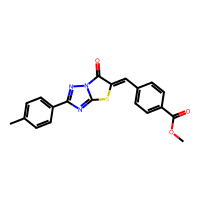
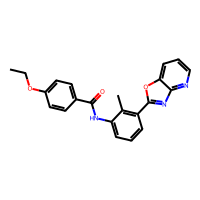
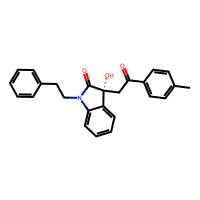

tokenized smile = ['C', 'C', 'O', 'c', '1', 'c', 'c', 'c', '(', 'C', '(', '=', 'O', ')', 'N', 'c', '2', 'c', 'c', 'c', 'c', '(', '-', 'c', '3', 'n', 'c', '4', 'n', 'c', 'c', 'c', 'c', '4', 'o', '3', ')', 'c', '2', 'C', ')', 'c', 'c', '1']


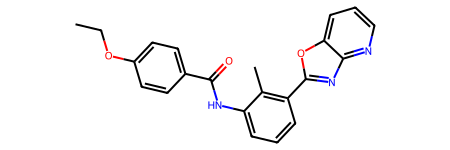

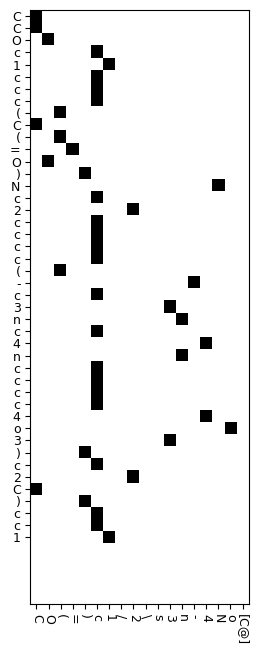

In [41]:
SMILESxtr = tokenization('./Molecules-data/smiles_prop.csv',reduceNumberOfMolTo=3,debug=True)
SMILESxtr.plot1pixelizedSmile(1,printMsg=True)
PandasTools.SaveXlsxFromFrame(SMILESxtr.df, './Molecules-data/smiles_prop_3xtr_WithTokenMol.xlsx', molCol='ROMol')

#### Misc.

In [42]:
def makeXY(data_train,data_valid):
    t4pPC.centerTitle("Making the training and validation sets")
    x_train = np.array(list(data_train['pixels'].values))
    y_train = data_train['log(P)'].values
    smiles_train = data_train['Smiles'].values
    index_train = data_train.index.values
    x_valid  = np.array(list(data_valid['pixels'].values))
    y_valid  = data_valid['log(P)'].values
    smiles_valid = data_valid['Smiles'].values
    index_valid = data_valid.index.values
    
    t4pPC.centertxt("Training set",size=14,weight='bold',bgc="#82c3c3",fgc="black")
    print("x_train: ",x_train.shape)
    print("y_train: ",y_train.shape)
    print("smiles_train: ",smiles_train.shape)
    t4pPC.centertxt("Validation set",size=14,weight='bold',bgc="#82c3c3",fgc="black")
    print("x_valid: ",x_valid.shape)
    print("y_valid: ",y_valid.shape)
    print("smiles_valid: ",smiles_valid.shape)
    return index_train,x_train,y_train,smiles_train,index_valid,x_valid,y_valid,smiles_valid


### Application to a 10k molecules dataset

#### Read the data & train-test split

Smiles  \
215828                  COc1cccc(OCCn2cc(C=O)c3ccccc32)c1   
406368  COc1cccc(-c2cn3c4c(=O)n(C)c(=O)n(C)c4nc3n2-c2c...   
188193                 CCN(CC)c1cccc(OC(=O)Nc2ccccc2Cl)c1   
221118   O=C(/C=C/c1ccccc1[N+](=O)[O-])Nc1nnc(C(F)(F)F)s1   
448481       O=C(Nc1ccc(Cl)c(NC(=O)c2ccco2)c1)c1ccc(I)cc1   
...                                                   ...   
223632  O=C(Cc1ccc([N+](=O)[O-])cc1)Nc1c[nH]c(=O)[nH]c1=O   
146602          COc1nc(N(C)C)nc(N(OC)S(=O)(=O)c2ccccc2)n1   
393785     Cc1cc(C)c2ccc(=O)n(CC(=O)N/N=C/c3ccccc3Cl)c2n1   
257440                Cc1ccc(SCCC(=O)Nc2c(C)cc(C)cc2C)cc1   
407622  CCOC(=O)c1ccc([C@H]2C(C(=O)OC)=C(N)OC3=C2C(=O)...   

        Molar Mass / g.mol-1   log(P)    TPSA  \
215828            295.120843  3.54140   40.46   
406368            485.131089  3.24980   84.69   
188193            318.113506  4.79710   41.57   
221118            344.019096  3.11700   98.02   
448481            465.958118  5.04220   71.34   
...                      ...      ...     ...   
223632            290.065119  0.15260  137.96   
146602            339.100125  0.70290   97.75   
393785            368.104003  2.81704   76.35   
257440            313.150035  5.04118   29.10   
407622            399.168188  2.96360  104.92   

                                     Canonicalized Smiles  
215828                  COc1cccc(OCCn2cc(C=O)c3ccccc32)c1  
406368  COc1cccc(-c2cn3c4c(=O)n(C)c(=O)n(C)c4nc3n2-c2c...  
188193                 CCN(CC)c1cccc(OC(=O)Nc2ccccc2Cl)c1  
221118   O=C(/C=C/c1ccccc1[N+](=O)[O-])Nc1nnc(C(F)(F)F)s1  
448481       O=C(Nc1ccc(Cl)c(NC(=O)c2ccco2)c1)c1ccc(I)cc1  
...                                                   ...  
223632  O=C(Cc1ccc([N+](=O)[O-])cc1)Nc1c[nH]c(=O)[nH]c1=O  
146602          COc1nc(N(C)C)nc(N(OC)S(=O)(=O)c2ccccc2)n1  
393785     Cc1cc(C)c2ccc(=O)n(CC(=O)N/N=C/c3ccccc3Cl)c2n1  
257440                Cc1ccc(SCCC(=O)Nc2c(C)cc(C)cc2C)cc1  
407622  CCOC(=O)c1ccc([C@H]2C(C(=O)OC)=C(N)OC3=C2C(=O)...  

[10000 rows x 5 columns]

dictionary : ['C', 'O', 'c', '1', '(', 'n', '2', '=', ')', '3', '-', '4', 'F', 'N', 'Cl', '/', '[N+]', '[O-]', 's', 'o', 'I', '[S@@]', '[NH+]', '[C@H]', '[C@@H]', 'S', 'Br', '#', '[nH]', '\\', '[H]', '[C@@]', '[C@]', '[NH3+]', '[nH+]', '[NH2+]', '[S-]', '[N-]', '[n+]', 'P', '5', '6', '[P@]', '7', '[n-]', '[P@@]', '[S@]', '[P@@H]']

the longuest word is made of 69 tokens, built on 16 unique tokens:['C', 'C', 'O', '/', 'C', '(', '[O-]', ')', '=', 'C', '1', '\\', 'C', '(', 'C', ')', '=', 'N', 'C', '2', '=', 'C', '(', 'C', '(', '=', 'O', ')', 'C', '[C@@H]', '(', 'c', '3', 'c', 'c', 'c', '(', 'O', 'C', ')', 'c', '(', 'O', 'C', ')', 'c', '3', ')', 'C', '2', ')', '[C@H]', '1', 'c', '1', 'c', 'c', 'c', 'c', '(', '[N+]', '(', '=', 'O', ')', '[O-]', ')', 'c', '1']


Smiles  \
215828                  COc1cccc(OCCn2cc(C=O)c3ccccc32)c1   
406368  COc1cccc(-c2cn3c4c(=O)n(C)c(=O)n(C)c4nc3n2-c2c...   
188193                 CCN(CC)c1cccc(OC(=O)Nc2ccccc2Cl)c1   
221118   O=C(/C=C/c1ccccc1[N+](=O)[O-])Nc1nnc(C(F)(F)F)s1   
448481       O=C(Nc1ccc(Cl)c(NC(=O)c2ccco2)c1)c1ccc(I)cc1   
...                                                   ...   
223632  O=C(Cc1ccc([N+](=O)[O-])cc1)Nc1c[nH]c(=O)[nH]c1=O   
146602          COc1nc(N(C)C)nc(N(OC)S(=O)(=O)c2ccccc2)n1   
393785     Cc1cc(C)c2ccc(=O)n(CC(=O)N/N=C/c3ccccc3Cl)c2n1   
257440                Cc1ccc(SCCC(=O)Nc2c(C)cc(C)cc2C)cc1   
407622  CCOC(=O)c1ccc([C@H]2C(C(=O)OC)=C(N)OC3=C2C(=O)...   

        Molar Mass / g.mol-1   log(P)    TPSA  \
215828            295.120843  3.54140   40.46   
406368            485.131089  3.24980   84.69   
188193            318.113506  4.79710   41.57   
221118            344.019096  3.11700   98.02   
448481            465.958118  5.04220   71.34   
...                      ...      ...     ...   
223632            290.065119  0.15260  137.96   
146602            339.100125  0.70290   97.75   
393785            368.104003  2.81704   76.35   
257440            313.150035  5.04118   29.10   
407622            399.168188  2.96360  104.92   

                                     Canonicalized Smiles  \
215828                  COc1cccc(OCCn2cc(C=O)c3ccccc32)c1   
406368  COc1cccc(-c2cn3c4c(=O)n(C)c(=O)n(C)c4nc3n2-c2c...   
188193                 CCN(CC)c1cccc(OC(=O)Nc2ccccc2Cl)c1   
221118   O=C(/C=C/c1ccccc1[N+](=O)[O-])Nc1nnc(C(F)(F)F)s1   
448481       O=C(Nc1ccc(Cl)c(NC(=O)c2ccco2)c1)c1ccc(I)cc1   
...                                                   ...   
223632  O=C(Cc1ccc([N+](=O)[O-])cc1)Nc1c[nH]c(=O)[nH]c1=O   
146602          COc1nc(N(C)C)nc(N(OC)S(=O)(=O)c2ccccc2)n1   
393785     Cc1cc(C)c2ccc(=O)n(CC(=O)N/N=C/c3ccccc3Cl)c2n1   
257440                Cc1ccc(SCCC(=O)Nc2c(C)cc(C)cc2C)cc1   
407622  CCOC(=O)c1ccc([C@H]2C(C(=O)OC)=C(N)OC3=C2C(=O)...   

                                            smiles2Tokens  \
215828  [C, O, c, 1, c, c, c, c, (, O, C, C, n, 2, c, ...   
406368  [C, O, c, 1, c, c, c, c, (, -, c, 2, c, n, 3, ...   
188193  [C, C, N, (, C, C, ), c, 1, c, c, c, c, (, O, ...   
221118  [O, =, C, (, /, C, =, C, /, c, 1, c, c, c, c, ...   
448481  [O, =, C, (, N, c, 1, c, c, c, (, Cl, ), c, (,...   
...                                                   ...   
223632  [O, =, C, (, C, c, 1, c, c, c, (, [N+], (, =, ...   
146602  [C, O, c, 1, n, c, (, N, (, C, ), C, ), n, c, ...   
393785  [C, c, 1, c, c, (, C, ), c, 2, c, c, c, (, =, ...   
257440  [C, c, 1, c, c, c, (, S, C, C, C, (, =, O, ), ...   
407622  [C, C, O, C, (, =, O, ), c, 1, c, c, c, (, [C@...   

                                                   pixels  \
215828  [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
406368  [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
188193  [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
221118  [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
448481  [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
...                                                   ...   
223632  [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
146602  [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
393785  [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
257440  [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
407622  [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                                   ROMol  
215828  <rdkit.Chem.rdchem.Mol object at 0x7fb59c002960>  
406368  <rdkit.Chem.rdchem.Mol object at 0x7fb59c002490>  
188193  <rdkit.Chem.rdchem.Mol object at 0x7fb59c0029d0>  
221118  <rdkit.Chem.rdchem.Mol object at 0x7fb59c0028f0>  
448481  <rdkit.Chem.rdchem.Mol object at 0x7fb59c0027a0>  
...                                                  ...  
223632  <rdkit.Chem.rdchem.Mol object at 0x7fb59c3e4c10>  
146602  <rdkit.Chem.rdchem.Mol object at 0x7fb59c3e4ba0>  
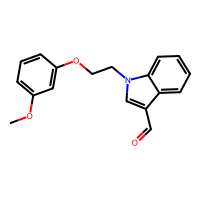
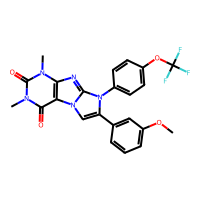
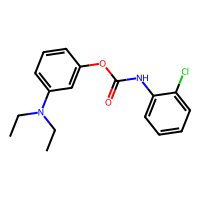
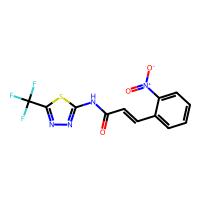
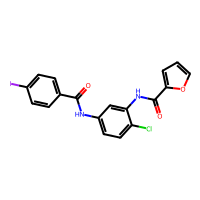
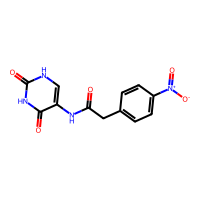
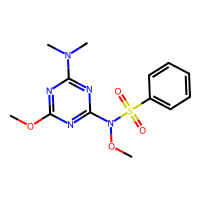
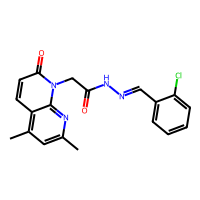
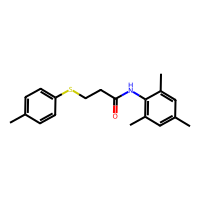
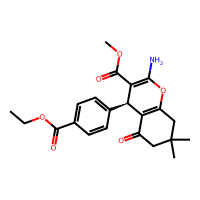


Duration :  00:00:04 398ms
Saving ML-SavedModels/autoencoders/10000SMILES_df.xlsx


In [63]:
nameOfDataFrame = '10000SMILES_df'
vID.chrono_start()
SMILESxtr = tokenization('./Molecules-data/smiles_prop.csv',reduceNumberOfMolTo=10000,debug=False)
vID.chrono_show()
saveDataFrame(SMILESxtr.df, nameOfDataFrame, MODELS_PATH=MODELS_PATH, df_extension="xlsx")

In [64]:
vID.chrono_start()
data_train = SMILESxtr.df.sample(frac=0.8, axis=0)
data_valid  = SMILESxtr.df.drop(data_train.index)
saveDataFrame(data_train, nameOfDataFrame+'_train', MODELS_PATH=MODELS_PATH, df_extension="pickle")
saveDataFrame(data_valid, nameOfDataFrame+'_valid', MODELS_PATH=MODELS_PATH, df_extension="pickle")

index_train,x_train,y_train,smiles_train,index_valid,x_valid,y_valid,smiles_valid = makeXY(data_train,data_valid)
vID.chrono_show()

filename = MODELS_PATH / f"{nameOfDataFrame}_tokenized.pickle"
t4pPC.centerTitle(f"Saving the token instance in {filename}")
print(filename)
SMILESxtr.pickle(filename)

Saving ML-SavedModels/autoencoders/10000SMILES_df_train.pickle
Saving ML-SavedModels/autoencoders/10000SMILES_df_valid.pickle


x_train:  (8000, 69, 48)
y_train:  (8000,)
smiles_train:  (8000,)


x_valid:  (2000, 69, 48)
y_valid:  (2000,)
smiles_valid:  (2000,)

Duration :  00:00:01 626ms


ML-SavedModels/autoencoders/10000SMILES_df_tokenized.pickle


#### Creation and compilation of the model

<div id="CompilationOfTheSMILESModel"></div>

/home/romuald/Python3/ML/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │       341,348 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 341,348 (1.30 MB)

 Trainable params: 341,348 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

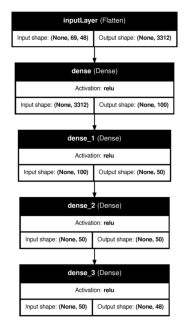

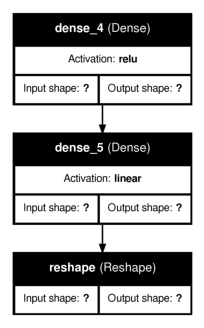

In [65]:
tf.keras.backend.clear_session()

tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

stacked_SMILESencoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[SMILESxtr.tokenSize[0],SMILESxtr.tokenSize[1]],name='inputLayer'),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(SMILESxtr.tokenSize[1], activation="relu"), #len of the dictionary. Why not? :-)
])

stacked_SMILESdecoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(SMILESxtr.tokenSize[0]*SMILESxtr.tokenSize[1]),
    tf.keras.layers.Reshape([SMILESxtr.tokenSize[0], SMILESxtr.tokenSize[1]])
    
])

stacked_edSMILESmodel = tf.keras.Sequential([stacked_SMILESencoder, stacked_SMILESdecoder])

#t4pPC.centerTitle("Summary of the model")
stacked_SMILESencoder.build()
stacked_SMILESdecoder.build()
stacked_edSMILESmodel.build()
stacked_edSMILESmodel.summary()

#t4pPC.centerTitle("Plot models")
plotModel(stacked_SMILESencoder, "StackedEncoder", MODELS_PATH=MODELS_PATH)
print()
plotModel(stacked_SMILESdecoder, "StackedDecoder", MODELS_PATH=MODELS_PATH)

#### Training

In [66]:
from tensorflow.keras.callbacks import EarlyStopping

metrics = ['mae']
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

vID.chrono_start()
stacked_edSMILESmodel.compile(loss="mse",
                              optimizer="nadam",
                              metrics = metrics
                             )
history_edSMILES = stacked_edSMILESmodel.fit(x_train, x_train,
                                             epochs=50,
                                             validation_data=(x_valid, x_valid),
                                             batch_size=100,
                                             callbacks=[es]
                                            )
vID.chrono_show()

Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0105 - mae: 0.0208 - val_loss: 0.0094 - val_mae: 0.0229
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0092 - mae: 0.0228 - val_loss: 0.0086 - val_mae: 0.0227
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0084 - mae: 0.0225 - val_loss: 0.0080 - val_mae: 0.0225
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0079 - mae: 0.0223 - val_loss: 0.0077 - val_mae: 0.0216
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0076 - mae: 0.0215 - val_loss: 0.0075 - val_mae: 0.0211
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0074 - mae: 0.0211 - val_loss: 0.0074 - val_mae: 0.0210
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0073 - mae: 0.0207 - val_loss: 0.0073 - val_mae: 0.0205
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0072 - mae: 0.0205 - val_loss: 0.0072 - val_mae: 0.0203
Epoch 9/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071 - mae: 

50
-0.0 0.1


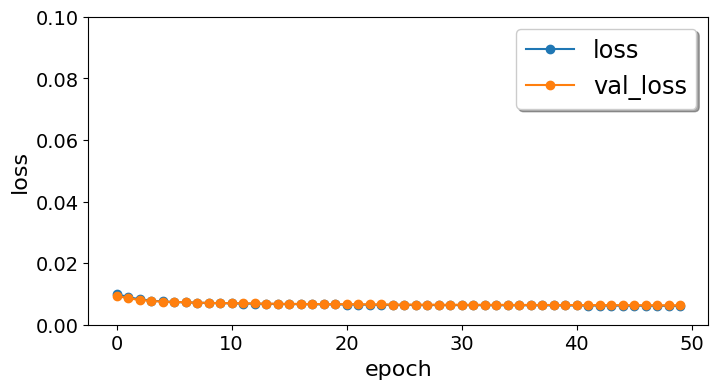

-0.0 0.1


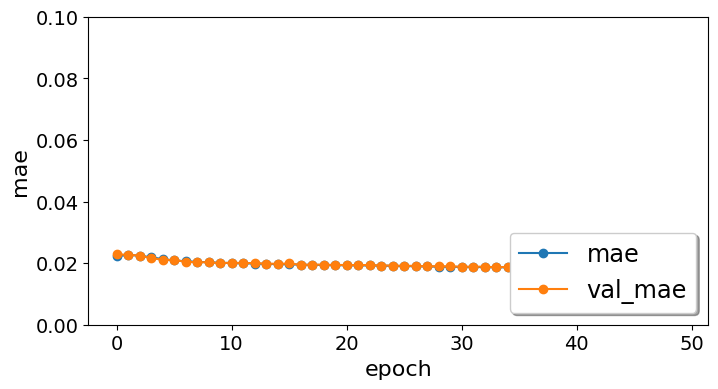

In [67]:
plotEpochs(history_edSMILES,metrics)

#### Save the models and the `tokenization` instance

In [68]:
from varname import nameof
file = MODELS_PATH / f"{nameof(stacked_edSMILESmodel)}.keras"
stacked_edSMILESmodel.save(file)

file = MODELS_PATH / f"{nameof(stacked_SMILESencoder)}.keras"
stacked_SMILESencoder.save(file)

file = MODELS_PATH / f"{nameof(stacked_SMILESdecoder)}.keras"
stacked_SMILESdecoder.save(file)

#### Jump to this section if you do not want to train the models again

<div class="rqT" title="warning">

Don't forget to <a href="#CompilationOfTheSMILESModel">first create and compile the models (autoencoder, but also encoder and decoder)</a>
</div>

Loading ML-SavedModels/autoencoders/10000SMILES_df_train.pickle
Loading ML-SavedModels/autoencoders/10000SMILES_df_valid.pickle


x_train:  (8000, 69, 48)
y_train:  (8000,)
smiles_train:  (8000,)


x_valid:  (2000, 69, 48)
y_valid:  (2000,)
smiles_valid:  (2000,)


Smiles  \
215828                  COc1cccc(OCCn2cc(C=O)c3ccccc32)c1   
406368  COc1cccc(-c2cn3c4c(=O)n(C)c(=O)n(C)c4nc3n2-c2c...   
188193                 CCN(CC)c1cccc(OC(=O)Nc2ccccc2Cl)c1   
221118   O=C(/C=C/c1ccccc1[N+](=O)[O-])Nc1nnc(C(F)(F)F)s1   
448481       O=C(Nc1ccc(Cl)c(NC(=O)c2ccco2)c1)c1ccc(I)cc1   
...                                                   ...   
223632  O=C(Cc1ccc([N+](=O)[O-])cc1)Nc1c[nH]c(=O)[nH]c1=O   
146602          COc1nc(N(C)C)nc(N(OC)S(=O)(=O)c2ccccc2)n1   
393785     Cc1cc(C)c2ccc(=O)n(CC(=O)N/N=C/c3ccccc3Cl)c2n1   
257440                Cc1ccc(SCCC(=O)Nc2c(C)cc(C)cc2C)cc1   
407622  CCOC(=O)c1ccc([C@H]2C(C(=O)OC)=C(N)OC3=C2C(=O)...   

        Molar Mass / g.mol-1   log(P)    TPSA  \
215828            295.120843  3.54140   40.46   
406368            485.131089  3.24980   84.69   
188193            318.113506  4.79710   41.57   
221118            344.019096  3.11700   98.02   
448481            465.958118  5.04220   71.34   
...                      ...      ...     ...   
223632            290.065119  0.15260  137.96   
146602            339.100125  0.70290   97.75   
393785            368.104003  2.81704   76.35   
257440            313.150035  5.04118   29.10   
407622            399.168188  2.96360  104.92   

                                     Canonicalized Smiles  \
215828                  COc1cccc(OCCn2cc(C=O)c3ccccc32)c1   
406368  COc1cccc(-c2cn3c4c(=O)n(C)c(=O)n(C)c4nc3n2-c2c...   
188193                 CCN(CC)c1cccc(OC(=O)Nc2ccccc2Cl)c1   
221118   O=C(/C=C/c1ccccc1[N+](=O)[O-])Nc1nnc(C(F)(F)F)s1   
448481       O=C(Nc1ccc(Cl)c(NC(=O)c2ccco2)c1)c1ccc(I)cc1   
...                                                   ...   
223632  O=C(Cc1ccc([N+](=O)[O-])cc1)Nc1c[nH]c(=O)[nH]c1=O   
146602          COc1nc(N(C)C)nc(N(OC)S(=O)(=O)c2ccccc2)n1   
393785     Cc1cc(C)c2ccc(=O)n(CC(=O)N/N=C/c3ccccc3Cl)c2n1   
257440                Cc1ccc(SCCC(=O)Nc2c(C)cc(C)cc2C)cc1   
407622  CCOC(=O)c1ccc([C@H]2C(C(=O)OC)=C(N)OC3=C2C(=O)...   

                                            smiles2Tokens  \
215828  [C, O, c, 1, c, c, c, c, (, O, C, C, n, 2, c, ...   
406368  [C, O, c, 1, c, c, c, c, (, -, c, 2, c, n, 3, ...   
188193  [C, C, N, (, C, C, ), c, 1, c, c, c, c, (, O, ...   
221118  [O, =, C, (, /, C, =, C, /, c, 1, c, c, c, c, ...   
448481  [O, =, C, (, N, c, 1, c, c, c, (, Cl, ), c, (,...   
...                                                   ...   
223632  [O, =, C, (, C, c, 1, c, c, c, (, [N+], (, =, ...   
146602  [C, O, c, 1, n, c, (, N, (, C, ), C, ), n, c, ...   
393785  [C, c, 1, c, c, (, C, ), c, 2, c, c, c, (, =, ...   
257440  [C, c, 1, c, c, c, (, S, C, C, C, (, =, O, ), ...   
407622  [C, C, O, C, (, =, O, ), c, 1, c, c, c, (, [C@...   

                                                   pixels  \
215828  [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
406368  [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
188193  [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
221118  [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
448481  [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
...                                                   ...   
223632  [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
146602  [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
393785  [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
257440  [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
407622  [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                                   ROMol  
215828  <rdkit.Chem.rdchem.Mol object at 0x7fb5c813c7c0>  
406368  <rdkit.Chem.rdchem.Mol object at 0x7fb5a97b4720>  
188193  <rdkit.Chem.rdchem.Mol object at 0x7fb5a97b46d0>  
221118  <rdkit.Chem.rdchem.Mol object at 0x7fb5a97b4680>  
448481  <rdkit.Chem.rdchem.Mol object at 0x7fb5a97b4630>  
...                                                  ...  
223632  <rdkit.Chem.rdchem.Mol object at 0x7fb5e005e340>  
146602  <rdkit.Chem.rdchem.Mol object at 0x7fb5e005e2f0>  
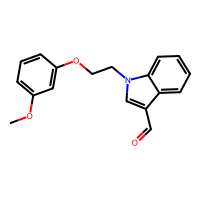
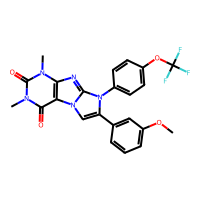
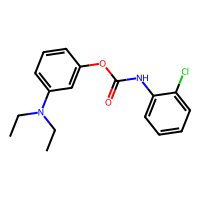
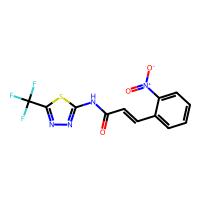
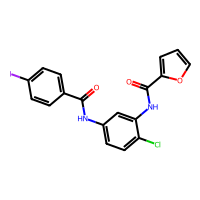
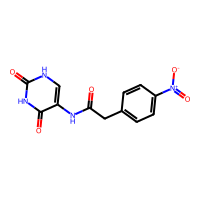
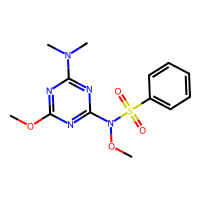
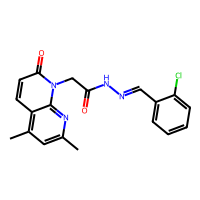
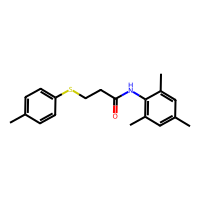
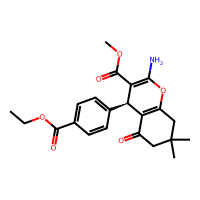

Dictionary =  ['C', 'O', 'c', '1', '(', 'n', '2', '=', ')', '3', '-', '4', 'F', 'N', 'Cl', '/', '[N+]', '[O-]', 's', 'o', 'I', '[S@@]', '[NH+]', '[C@H]', '[C@@H]', 'S', 'Br', '#', '[nH]', '\\', '[H]', '[C@@]', '[C@]', '[NH3+]', '[nH+]', '[NH2+]', '[S-]', '[N-]', '[n+]', 'P', '5', '6', '[P@]', '7', '[n-]', '[P@@]', '[S@]', '[P@@H]']

Longest word =  ['C', 'C', 'O', '/', 'C', '(', '[O-]', ')', '=', 'C', '1', '\\', 'C', '(', 'C', ')', '=', 'N', 'C', '2', '=', 'C', '(', 'C', '(', '=', 'O', ')', 'C', '[C@@H]', '(', 'c', '3', 'c', 'c', 'c', '(', 'O', 'C', ')', 'c', '(', 'O', 'C', ')', 'c', '3', ')', 'C', '2', ')', '[C@H]', '1', 'c', '1', 'c', 'c', 'c', 'c', '(', '[N+]', '(', '=', 'O', ')', '[O-]', ')', 'c', '1']


In [69]:
t4pPC.centerTitle("Reading the trained models")
from varname import nameof
file = MODELS_PATH / f"{nameof(stacked_edSMILESmodel)}.keras"
stacked_edSMILESmodel = keras.models.load_model(file)

file = MODELS_PATH / f"{nameof(stacked_SMILESencoder)}.keras"
stacked_SMILESencoder = keras.models.load_model(file)

file = MODELS_PATH / f"{nameof(stacked_SMILESdecoder)}.keras"
stacked_SMILESdecoder = keras.models.load_model(file)

file_train = nameOfDataFrame+'_train'
file_valid = nameOfDataFrame+'_valid'
t4pPC.centerTitle(f"Reading training and validation dataframes, in {file_train} and {file_valid}")
data_train = loadDataFrame(file_train, MODELS_PATH=MODELS_PATH, df_extension="pickle")
data_valid = loadDataFrame(file_valid, MODELS_PATH=MODELS_PATH, df_extension="pickle")

index_train, x_train, y_train, smiles_train, index_valid, x_valid, y_valid, smiles_valid = makeXY(data_train,data_valid)


filename = MODELS_PATH / f"{nameOfDataFrame}_tokenized.pickle"
t4pPC.centerTitle(f"Reading the tokenized dataframe, in {filename}")
SMILESxtr = tokenization.unpickle(filename)
display(SMILESxtr.df)
print("Dictionary = ",SMILESxtr.dictionary)
print()
print("Longest word = ",SMILESxtr.longestWord)

#### Visualize the reconstructions and the latent space

<div class="intro">

<img width="10%" src="./DS4B-Slides/pngs/ZooNN/AE-C.png" style="display:block; margin-left:auto; margin-right:auto" id="AE"/> 
</div>

In [70]:
# t = np.array([[0,0,0.2,1],
#              [3.,0.1,0.2,1],
#              [0.1,0.6,0.2,0.1],
#              [0.2,0.25,0.02,0.1]])
# print(t)

# for irow in range(t.shape[0]):
#     row = t[irow,:]
#     row2 = np.zeros_like(row)
#     print(row, max(row),np.argmax(row))
#     if np.max(row) >= 0.3:
#         row2[np.where(row==np.max(row))] = 1
#     print(row2)
#     t[irow,:] = row2

# print(t)

Index of the molecule = 13159
(69, 48)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
shape =  (1, 69, 48)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


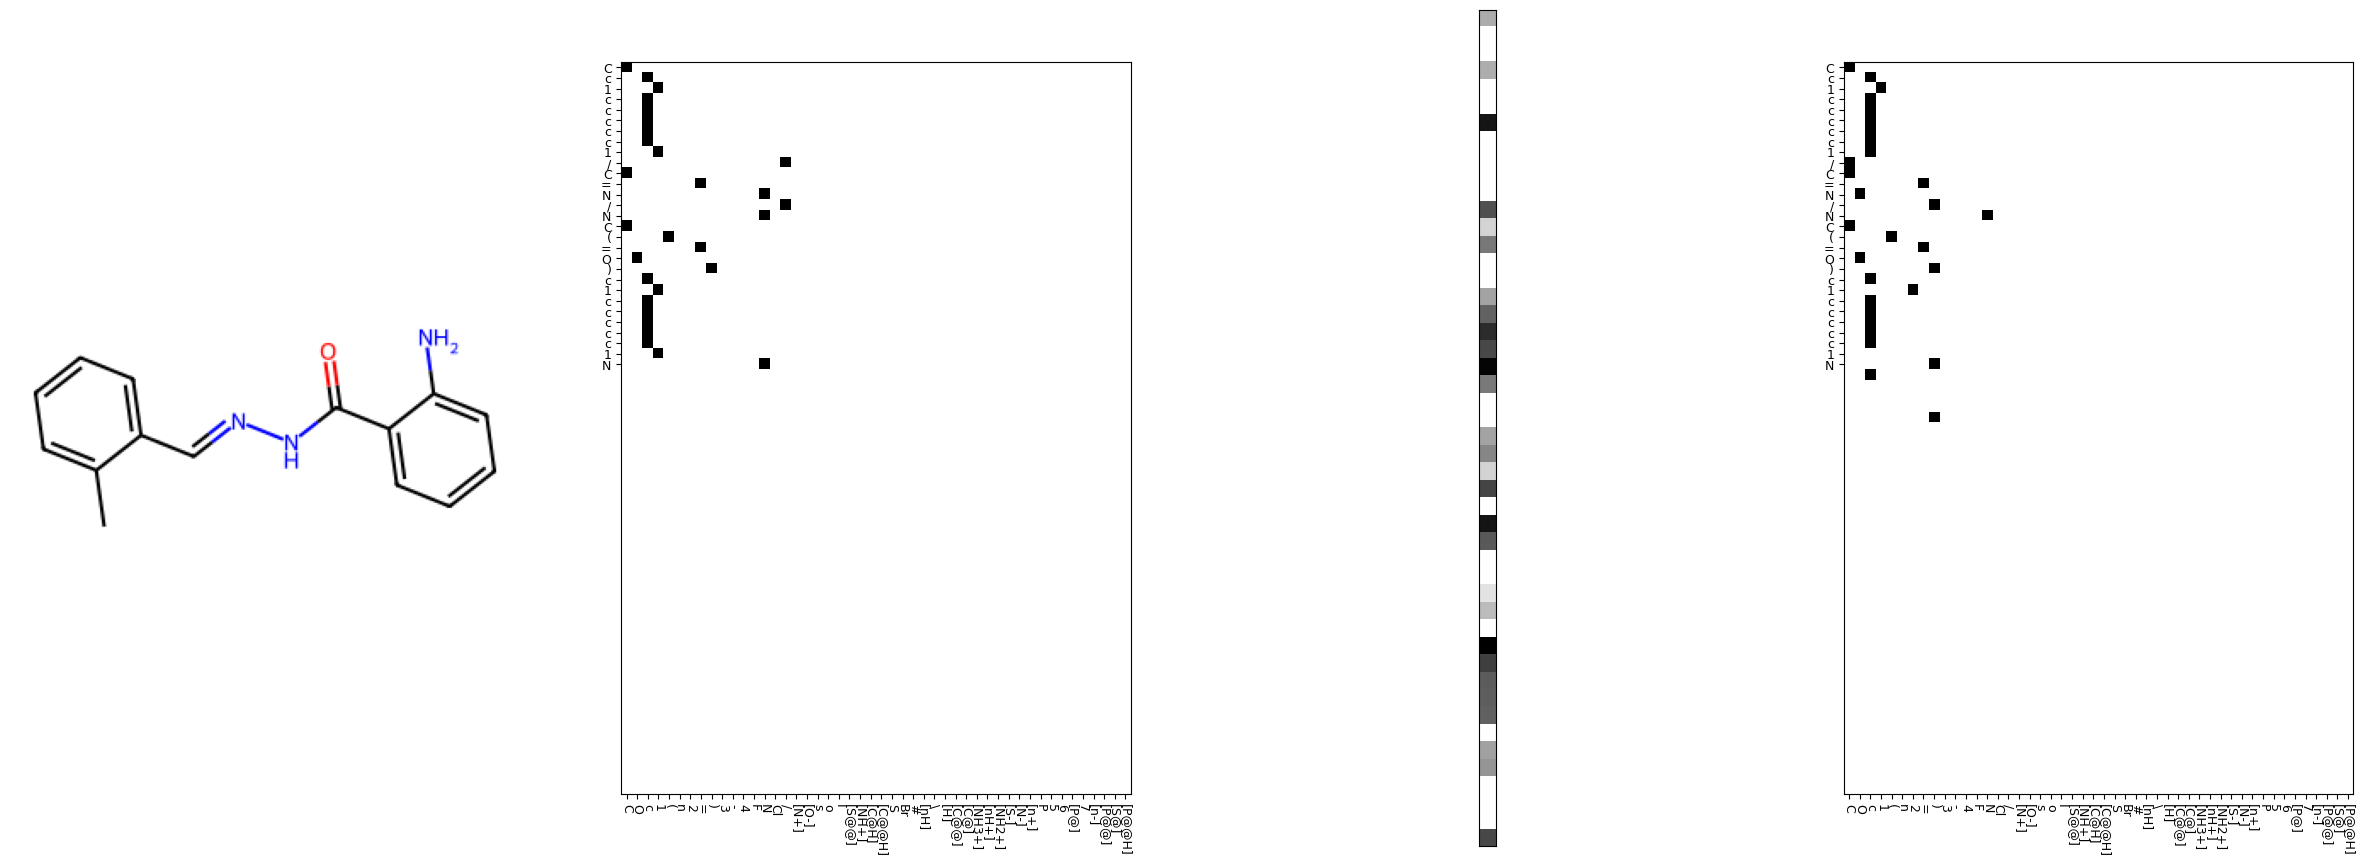

Index of the molecule = 57961
(69, 48)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
shape =  (1, 69, 48)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


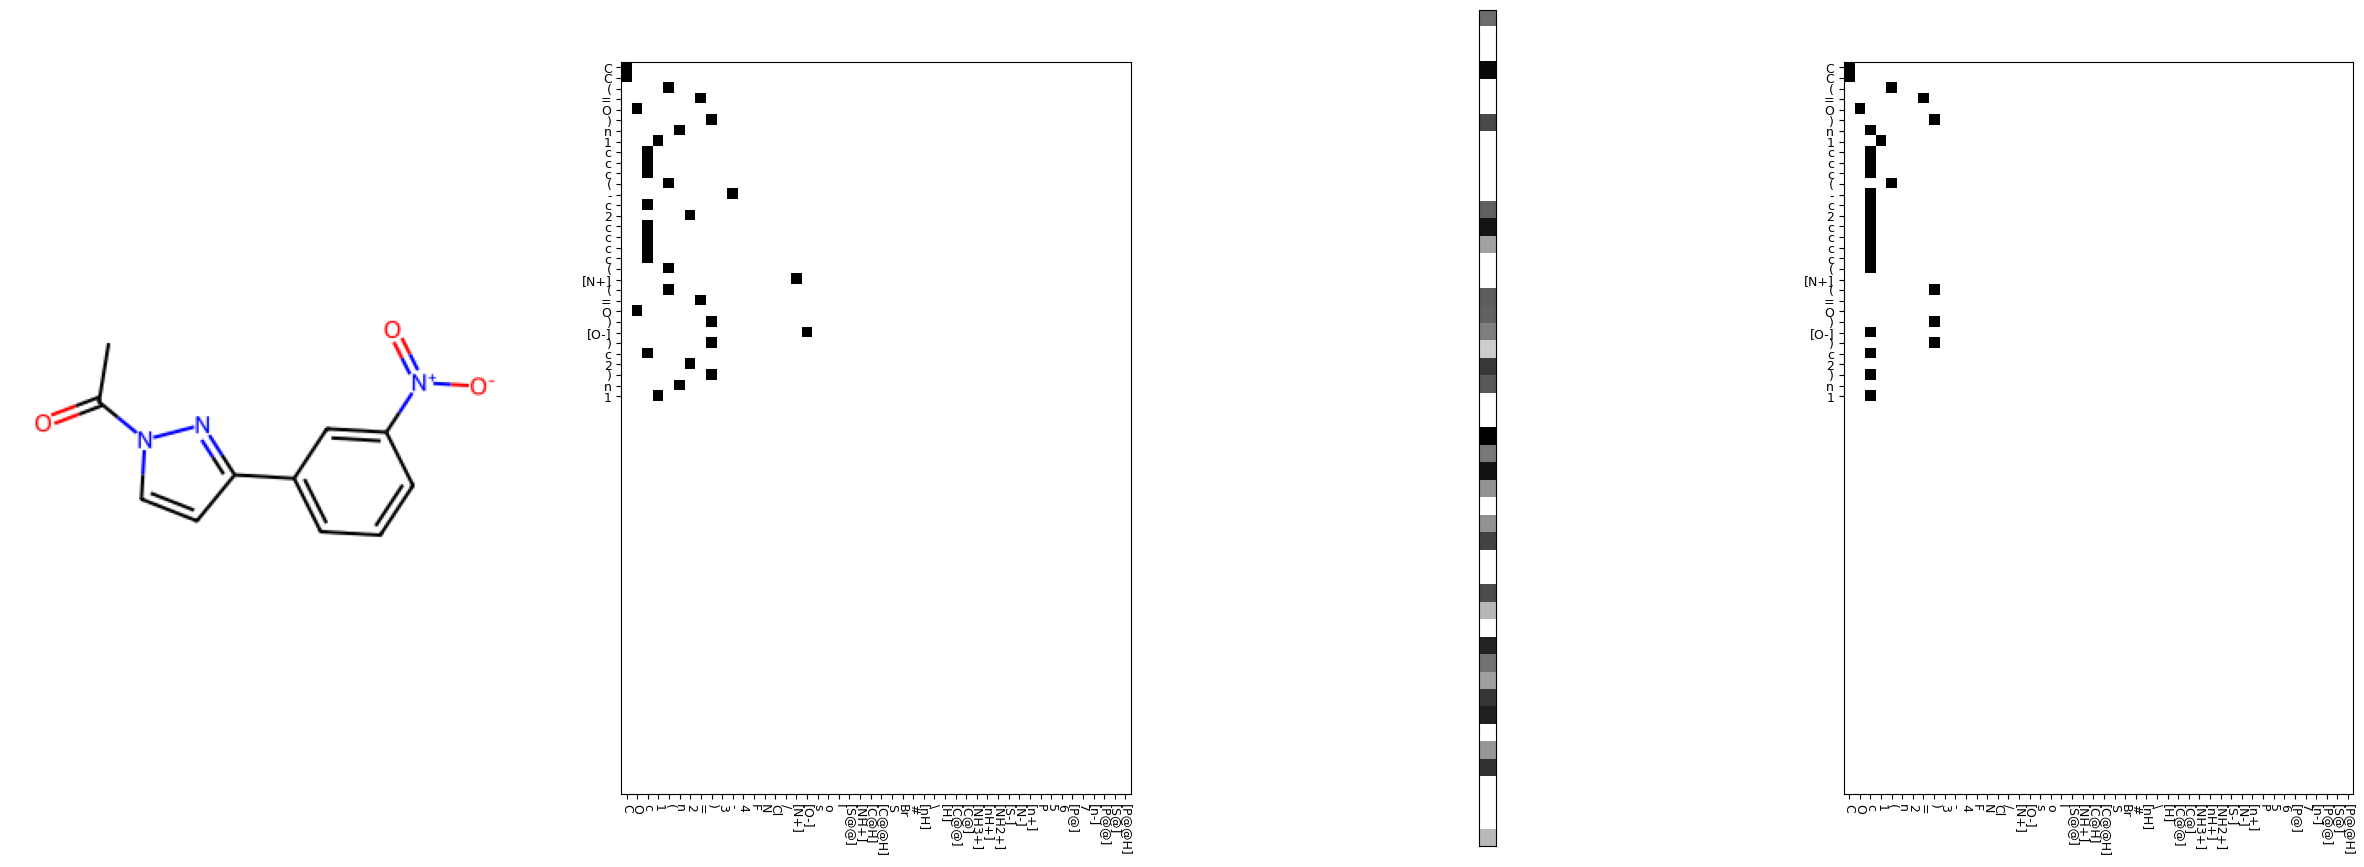

In [71]:
compareReconstructionsWithOriginalTokens(SMILESxtr, stacked_SMILESencoder, stacked_edSMILESmodel, index_train, x_train, smiles_train, indexMol = 10)
compareReconstructionsWithOriginalTokens(SMILESxtr, stacked_SMILESencoder, stacked_edSMILESmodel, index_valid, x_valid, smiles_valid, indexMol = 10)

#### Visualization of the latent space

In [72]:
vID.chrono_start()
from sklearn.manifold import TSNE
x_validEncoded = stacked_SMILESencoder.predict(x_valid)
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
x_validEncoded2D = tsne.fit_transform(x_validEncoded)
vID.chrono_show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Duration :  00:00:10 335ms


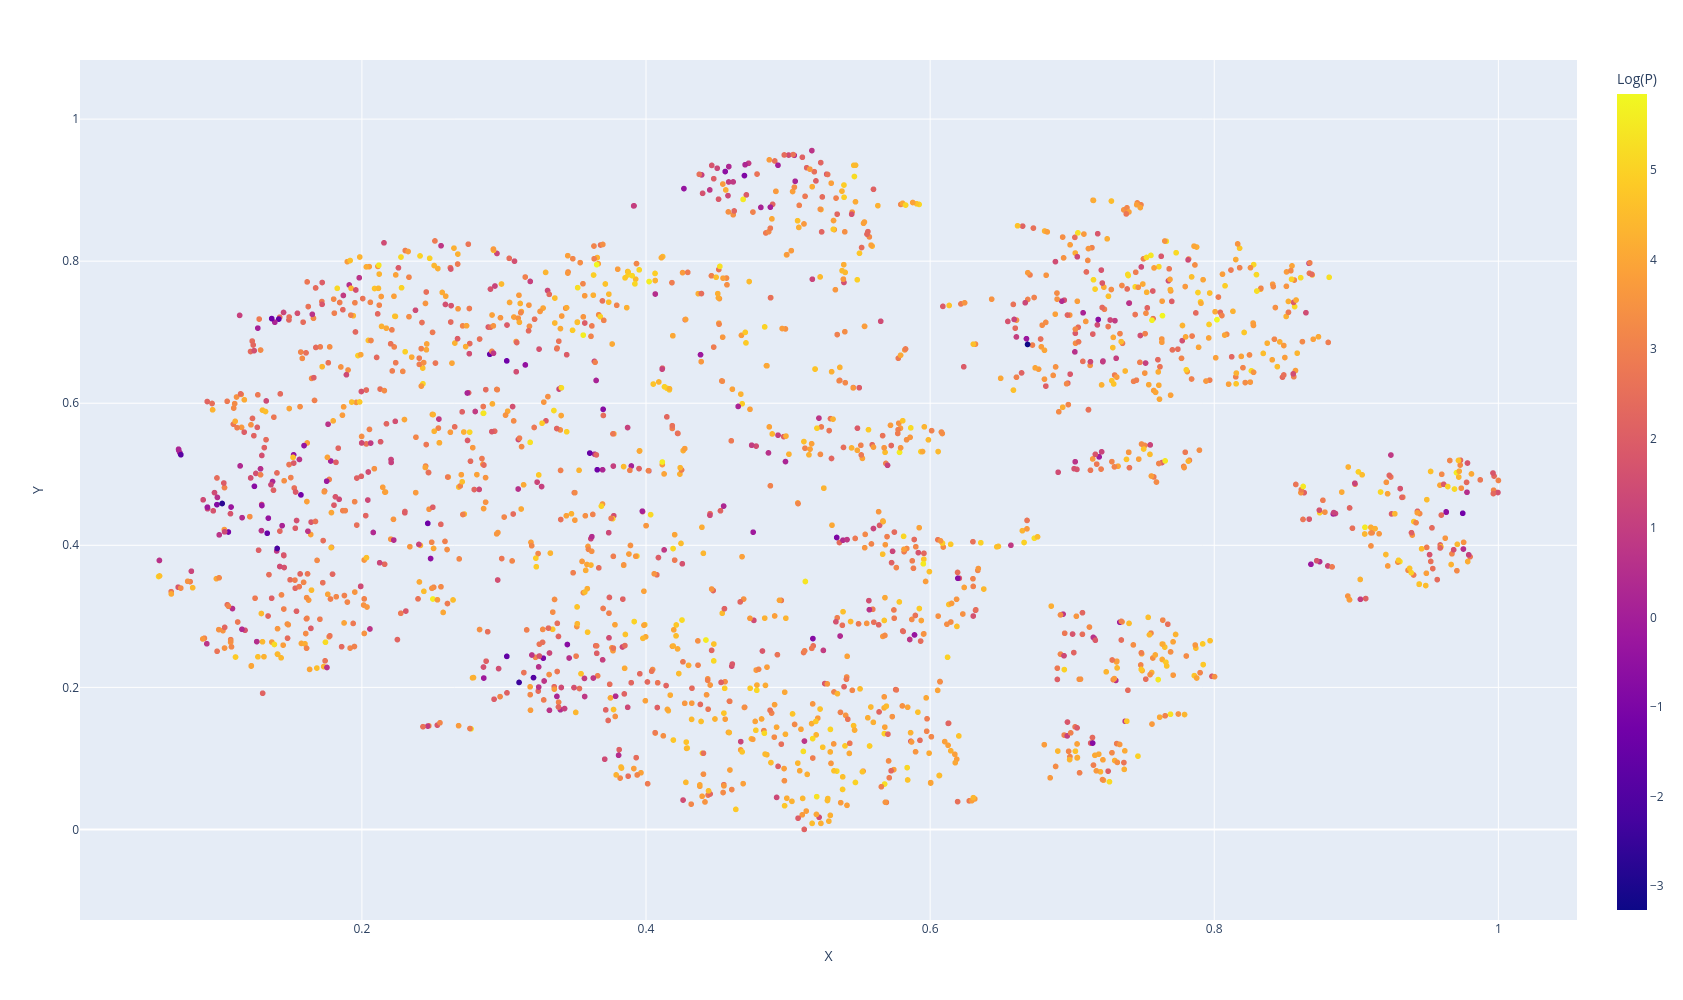

/home/romuald/Python3/ML/lib/python3.11/site-packages/dash/dash.py:556: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



In [73]:
import plotly.express as px
import molplotly

Z = x_validEncoded2D.copy()
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
cm2i = 1/2.54

temp_df = pd.DataFrame({
    'X': Z[:, 0],
    'Y': Z[:, 1],
    'Log(P)': y_valid,
    'smiles': smiles_valid,
})

# Create a scatter plot with plotly
fig = px.scatter(temp_df, x='X', y='Y', color='Log(P)', hover_data=['smiles'])

fig.update_layout(
    width=1000,  # Adjust width and height if necessary
    height=1000,
    xaxis=dict(scaleanchor='y', scaleratio=2),
    yaxis=dict(scaleanchor='x', scaleratio=2)
)
# Add molecules with molplotly
app = molplotly.add_molecules(
    fig=fig,
    df=temp_df,
    smiles_col='smiles',
    title_col='Log(P)'
)

# Run the application
app.run(mode='inline', port=8768, height=1600)

### Same 10k data set, but with a sparse autoencoder

<div class="intro">

The sparsity constraint is typically enforced by adding a penalty term to the loss function that encourages the activations of the hidden units to be sparse. The sparsity proportion is another **hyperparameter** that determines the desired level of sparsity in the activations. Sparse autoencoders are particularly useful when the dimensionality of the input data is high, as they can learn a lower-dimensional representation that captures the most important features of the data. As said in A. Géron's book: "*each neuron in the coding layer typically ends up representing a useful feature (if you could speak only a few words per month, you would probably try to make them worth listening to)*" 
</div>

#### Datas

In [ ]:
# read the data
nameOfDataFrame = '10000SMILES_df'
vID.chrono_start()
SMILESxtr = tokenization('./Molecules-data/smiles_prop.csv',reduceNumberOfMolTo=10000,debug=False)
vID.chrono_show()
saveDataFrame(SMILESxtr.df, nameOfDataFrame, MODELS_PATH=MODELS_PATH, df_extension="xlsx")

# Make training and validation sets
vID.chrono_start()
data_train = SMILESxtr.df.sample(frac=0.8, axis=0)
data_valid  = SMILESxtr.df.drop(data_train.index)
saveDataFrame(data_train, nameOfDataFrame+'_train', MODELS_PATH=MODELS_PATH, df_extension="pickle")
saveDataFrame(data_valid, nameOfDataFrame+'_valid', MODELS_PATH=MODELS_PATH, df_extension="pickle")

index_train,x_train,y_train,smiles_train,index_valid,x_valid,y_valid,smiles_valid = makeXY(data_train,data_valid)
vID.chrono_show()

filename = MODELS_PATH / f"{nameOfDataFrame}_tokenized.pickle"
t4pPC.centerTitle(f"Saving the token instance in {filename}")
print(filename)
SMILESxtr.pickle(filename)


#### Creation of the model and training

<div class="intro">

A simple approach is to use the sigmoid activation function in the coding layer (to constrain the codings to values between 0 and 1), use a large coding layer (e.g.  with 300 neurons), and add some &ell;<sub>1</sub> regularization to the coding layer’s activations.
</div>

In [ ]:
# Creation  and compilation of the model
tf.keras.backend.clear_session()

tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

stacked_SMILESencoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[SMILESxtr.tokenSize[0],SMILESxtr.tokenSize[1]],name='inputLayer'),
    tf.keras.layers.Dense(100, activation="relu",name='hLayer1'),
    tf.keras.layers.Dense(50, activation="relu", name='hLayer2'),
    tf.keras.layers.Dense(50, activation="relu", name='hLayer3'),
    tf.keras.layers.Dense(100, activation="sigmoid"), #len of the dictionary
    tf.keras.layers.ActivityRegularization(l1=1e-2)
])

stacked_SMILESdecoder = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(SMILESxtr.tokenSize[0]*SMILESxtr.tokenSize[1]),
    tf.keras.layers.Reshape([SMILESxtr.tokenSize[0], SMILESxtr.tokenSize[1]])
])

stacked_edSMILESmodel = tf.keras.Sequential([stacked_SMILESencoder, stacked_SMILESdecoder])

#t4pPC.centerTitle("Summary of the model")
stacked_SMILESencoder.build()
stacked_SMILESdecoder.build()
stacked_edSMILESmodel.build()
stacked_edSMILESmodel.summary()

#t4pPC.centerTitle("Plot models")
plotModel(stacked_SMILESencoder, "StackedEncoder", MODELS_PATH=MODELS_PATH)
print()
plotModel(stacked_SMILESdecoder, "StackedDecoder", MODELS_PATH=MODELS_PATH)

# Training
from tensorflow.keras.callbacks import EarlyStopping

metrics = ['mae']
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

vID.chrono_start()
stacked_edSMILESmodel.compile(loss="mse",
                              optimizer="nadam",
                              metrics = metrics
                             )
history_edSMILES = stacked_edSMILESmodel.fit(x_train, x_train,
                                             epochs=50,
                                             validation_data=(x_valid, x_valid),
                                             batch_size=100,
                                             callbacks=[es]
                                            )
vID.chrono_show()

#### Visualize the reconstructions and the latent space

<div class="intro">

<img width="10%" src="./DS4B-Slides/pngs/ZooNN/AE-C.png" style="display:block; margin-left:auto; margin-right:auto" id="AE"/> 
</div>

In [ ]:
compareReconstructionsWithOriginalTokens(SMILESxtr, stacked_SMILESencoder, stacked_edSMILESmodel, index_train, x_train, smiles_train, indexMol = 1260)
compareReconstructionsWithOriginalTokens(SMILESxtr, stacked_SMILESencoder, stacked_edSMILESmodel, index_valid, x_valid, smiles_valid, indexMol = 12)

<div class="rq">
It is obviously not working in this case
</div>

## Autoencoders applied to rdf profiles

<div class="intro">

See the [1D convolutional NN notebook](ML-1DCNN.ipynb) for an introduction to RDFs
</div>

### Useful functions and initialization of variables

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
from scipy.signal import find_peaks

pathway2rdfExp = "./ML-data/RDFs/expRDF/"

pathway = "./ML-data/RDFs/simulRDF/"


def rescale1D(x,f,peakref,xmax,dxTarget):
    import numpy as np
    dx = x[1]-x[0]
    f = f/f[peakref]
    x = x/x[peakref]
    xmaxTarget = xmax / x[peakref]
    xnew = np.arange(0,xmaxTarget,dxTarget)
    ynew = np.interp(xnew, x, f)
    return xnew,ynew

def makeXY(data_train,data_valid):
    t4pPC.centerTitle("Making the training and validation sets")
    x_train = np.array(list(data_train.drop(['Shape'],axis=1).values))
    y_train = data_train['Shape'].values
    index_train = data_train.index.values
    x_valid  = np.array(list(data_valid.drop(['Shape'],axis=1).values))
    y_valid  = data_valid['Shape'].values
    index_valid = data_valid.index.values
    
    t4pPC.centertxt("Training set",size=14,weight='bold',bgc="#82c3c3",fgc="black")
    print("x_train: ",x_train.shape)
    print("y_train: ",y_train.shape)
    t4pPC.centertxt("Validation set",size=14,weight='bold',bgc="#82c3c3",fgc="black")
    print("x_valid: ",x_valid.shape)
    print("y_valid: ",y_valid.shape)
    return index_train,x_train,y_train,index_valid,x_valid,y_valid

def ShowRDFLatentSpaceRepresentation(encoder, decoder, ae, RDF_Dataset, shapes, rStep, RDF_index):
    from scipy.signal import find_peaks
    import numpy as np
    nSteps = RDF_Dataset.shape[1]
    img = RDF_Dataset[RDF_index].reshape(1,nSteps)
    rValues = np.arange(0,nSteps*rStep,rStep)
    print(f"Shape of the NP = {shapes[RDF_index]}")
    print(f"Shape of the RDF input profile = {img.shape}")
    LatentSpaceRepresentation = encoder.predict(img)
    Reconstructed_img = decoder.predict(LatentSpaceRepresentation)
    print(Reconstructed_img.shape)
    Reconstructed_img = Reconstructed_img.reshape(nSteps)
    plt.rc('font', size=14)
    plt.rc('axes', labelsize=14, titlesize=12)
    plt.rc('legend', fontsize=14)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.subplots(1, 2, gridspec_kw={"width_ratios": [2, 4]}, figsize=(18, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(LatentSpaceRepresentation, cmap='binary', interpolation="nearest")
    plt.yticks([])
    plt.subplot(1, 2, 2) 
    plt.plot(rValues,RDF_Dataset[RDF_index],label='original RDF')
    plt.plot(rValues,Reconstructed_img,label='decoded RDF',ls='--')
    plt.legend()
    plt.show()
    return LatentSpaceRepresentation, Reconstructed_img

### Data

#### Read the data

In [4]:
import pandas as pd
import numpy as np

import os

csv1DF = pathway+"RDF_profiles.csv"
csv1DL = pathway+"RDF_labels.csv"

if os.path.exists(csv1DF) and os.path.exists(csv1DL):
    dfF=pd.read_csv(csv1DF, sep="\t", index_col = 0) 
    dfY=pd.read_csv(csv1DL, sep="\t", index_col = 0) 
    print(f"dfF. Structure (shape) :{dfF.shape}")
    print(f"dfY. Structure (shape) :{dfY.shape}")
    display(dfF)
    display(dfY)
    rStep = dfF['r'].iloc[1]- dfF['r'].iloc[0]
else:
    print(f'{csv1DF} and/or {csv1DL} were not found')
    print('Create first these files, by running the codes of the appendix of the present notebook') 

print(rStep)

dfF. Structure (shape) :(2541, 1030)
dfY. Structure (shape) :(1029, 1)


r  hcpsph2_000_000  hcpsph2_000_001  hcpsph2_000_002  \
0      0.000              0.0              0.0              0.0   
1      0.025              0.0              0.0              0.0   
2      0.050              0.0              0.0              0.0   
3      0.075              0.0              0.0              0.0   
4      0.100              0.0              0.0              0.0   
...      ...              ...              ...              ...   
2536  63.400              0.0              0.0              0.0   
2537  63.425              0.0              0.0              0.0   
2538  63.450              0.0              0.0              0.0   
2539  63.475              0.0              0.0              0.0   
2540  63.500              0.0              0.0              0.0   

      hcpsph2_000_003  hcpsph2_000_004  hcpsph2_000_005  hcpsph2_000_006  \
0                 0.0              0.0              0.0              0.0   
1                 0.0              0.0              0.0              0.0   
2                 0.0              0.0              0.0              0.0   
3                 0.0              0.0              0.0              0.0   
4                 0.0              0.0              0.0              0.0   
...               ...              ...              ...              ...   
2536              0.0              0.0              0.0              0.0   
2537              0.0              0.0              0.0              0.0   
2538              0.0              0.0              0.0              0.0   
2539              0.0              0.0              0.0              0.0   
2540              0.0              0.0              0.0              0.0   

      hcpsph2_000_007  hcpsph2_000_008  ...  bccCube_030_011  bccCube_030_012  \
0                 0.0              0.0  ...              0.0              0.0   
1                 0.0              0.0  ...              0.0              0.0   
2                 0.0              0.0  ...              0.0              0.0   
3                 0.0              0.0  ...              0.0              0.0   
4                 0.0              0.0  ...              0.0              0.0   
...               ...              ...  ...              ...              ...   
2536              0.0              0.0  ...              0.0              0.0   
2537              0.0              0.0  ...              0.0              0.0   
2538              0.0              0.0  ...              0.0              0.0   
2539              0.0              0.0  ...              0.0              0.0   
2540              0.0              0.0  ...              0.0              0.0   

      bccCube_030_013  bccCube_030_014  bccCube_030_015  bccCube_030_016  \
0                 0.0              0.0              0.0              0.0   
1                 0.0              0.0              0.0              0.0   
2                 0.0              0.0              0.0              0.0   
3                 0.0              0.0              0.0              0.0   
4                 0.0              0.0              0.0              0.0   
...               ...              ...              ...              ...   
2536              0.0              0.0              0.0              0.0   
2537              0.0              0.0              0.0              0.0   
2538              0.0              0.0              0.0              0.0   
2539              0.0              0.0              0.0              0.0   
2540              0.0              0.0              0.0              0.0   

      bccCube_030_017  bccCube_030_018  bccCube_030_019  bccCube_030_020  
0                 0.0              0.0              0.0              0.0  
1                 0.0              0.0              0.0              0.0  
2                 0.0              0.0              0.0              0.0  
3                 0.0              0.0              0.0              0.0  
4                 0.0           

F
hcpsph2_000_000  hcpsph2
hcpsph2_000_001  hcpsph2
hcpsph2_000_002  hcpsph2
hcpsph2_000_003  hcpsph2
hcpsph2_000_004  hcpsph2
...                  ...
bccCube_030_016  bccCube
bccCube_030_017  bccCube
bccCube_030_018  bccCube
bccCube_030_019  bccCube
bccCube_030_020  bccCube

[1029 rows x 1 columns]

0.025


#### Standardization

In [5]:
RDFcols = list(dfF.columns)
RDFcols.remove('r')
dfFS = dfF.copy()
dfFS = dfFS.drop('r',axis='columns')
for nameRDF in RDFcols:
    peaks, _ = find_peaks(dfFS[nameRDF],height=1)
    peakRef = peaks[0]
    # print(peaks[0], rvalues[peaks[0]],dfFS[nameRDF].iloc[peaks[0]])
    dfFS[nameRDF] = dfFS[nameRDF]/dfFS[nameRDF].iloc[peaks[0]]

deltaR = dfF['r'].iloc[1] - dfF['r'].iloc[0]
Rmax = 10
nrows = int(Rmax / deltaR)
print(f"{bg.LIGHTBLUEB}Keeping {nrows} rows, such that Rmax = {Rmax} Å (δr = {deltaR} Å)")
dfFS = dfFS.iloc[np.linspace(0,nrows,nrows)]
display(dfFS)
display(dfFS.describe().style.format("{0:.2f}").set_caption("Training set after rescaling wrt intensity"))

Keeping 400 rows, such that Rmax = 10 Å (δr = 0.025 Å)


hcpsph2_000_000  hcpsph2_000_001  hcpsph2_000_002  hcpsph2_000_003  \
0           0.000000         0.000000         0.000000         0.000000   
1           0.000000         0.000000         0.000000         0.000000   
2           0.000000         0.000000         0.000000         0.000000   
3           0.000000         0.000000         0.000000         0.000000   
4           0.000000         0.000000         0.000000         0.000000   
..               ...              ...              ...              ...   
395         0.018392         0.032138         0.039805         0.047515   
396         0.030741         0.031673         0.038107         0.049954   
397         0.043938         0.033869         0.038680         0.049842   
398         0.049646         0.038346         0.041032         0.046801   
400         0.032051         0.047670         0.044556         0.038658   

     hcpsph2_000_004  hcpsph2_000_005  hcpsph2_000_006  hcpsph2_000_007  \
0           0.000000         0.000000         0.000000         0.000000   
1           0.000000         0.000000         0.000000         0.000000   
2           0.000000         0.000000         0.000000         0.000000   
3           0.000000         0.000000         0.000000         0.000000   
4           0.000000         0.000000         0.000000         0.000000   
..               ...              ...              ...              ...   
395         0.037926         0.040064         0.046822         0.042524   
396         0.036556         0.042539         0.048391         0.045466   
397         0.035685         0.045910         0.048413         0.047010   
398         0.034963         0.048562         0.046592         0.046947   
400         0.034539         0.047382         0.041462         0.044402   

     hcpsph2_000_008  hcpsph2_000_009  ...  bccCube_030_011  bccCube_030_012  \
0           0.000000         0.000000  ...         0.000000         0.000000   
1           0.000000         0.000000  ...         0.000000         0.000000   
2           0.000000         0.000000  ...         0.000000         0.000000   
3           0.000000         0.000000  ...         0.000000         0.000000   
4           0.000000         0.000000  ...         0.000000         0.000000   
..               ...              ...  ...              ...              ...   
395         0.044859         0.035041  ...         0.521395         0.514253   
396         0.044905         0.039207  ...         0.484547         0.478145   
397         0.044332         0.042740  ...         0.453618         0.448500   
398         0.044118         0.043654  ...         0.428041         0.425087   
400         0.042455         0.038549  ...         0.390983         0.390798   

     bccCube_030_013  bccCube_030_014  bccCube_030_015  bccCube_030_016  \
0           0.000000         0.000000         0.000000         0.000000   
1           0.000000         0.000000         0.000000         0.000000   
2           0.000000         0.000000         0.000000         0.000000   
3           0.000000         0.000000         0.000000         0.000000   
4           0.000000         0.000000         0.000000         0.000000   
..               ...              ...              ...              ...   
395         0.533330         0.523534         0.517922         0.524840   
396         0.493373         0.483138         0.480944         0.484867   
397         0.459381         0.449361         0.449268         0.451076   
398         0.432877         0.422510         0.423350         0.424933   
400         0.400543         0.384303         0.385256         0.392104   

     bccCube_030_017  bccCube_030_018  bccCube_030_019  bccCube_030_020  
0           0.000000         0.000000         0.000000         0.000000  
1           0.000000         0.000000         0.000000         0.000000  
2           0.000000         0.000000         0.000000         0.000000  
3           0.000000         0.000000        

#### Construction of the relevant dataframe for training

In [6]:
dfFS = dfFS.T
nlines = dfFS.shape[0]
ncols = dfFS.shape[1]
dfFS["Shape"]=dfY["F"]
uv = dfFS["Shape"].unique()
print(f"{len(uv):2} unique categories: {uv}") 
display(dfFS)

11 unique categories: ['hcpsph2' 'fccCube' 'regfccOh' 'bccrDD' 'cubo' 'pbpy' 'fccdrDD' 'dd'
 'fccTrOh' 'ico' 'bccCube']


0    1    2    3    4    5    6    7    8    9  ...  \
hcpsph2_000_000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
hcpsph2_000_001  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
hcpsph2_000_002  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
hcpsph2_000_003  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
hcpsph2_000_004  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
...              ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
bccCube_030_016  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
bccCube_030_017  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
bccCube_030_018  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
bccCube_030_019  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
bccCube_030_020  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

                      391       392       393       394       395       396  \
hcpsph2_000_000  0.044650  0.031063  0.018485  0.013540  0.018392  0.030741   
hcpsph2_000_001  0.052456  0.047226  0.040595  0.035177  0.032138  0.031673   
hcpsph2_000_002  0.049534  0.048582  0.046159  0.042925  0.039805  0.038107   
hcpsph2_000_003  0.050749  0.047600  0.044996  0.045044  0.047515  0.049954   
hcpsph2_000_004  0.042097  0.040880  0.040309  0.039408  0.037926  0.036556   
...                   ...       ...       ...       ...       ...       ...   
bccCube_030_016  0.688929  0.652147  0.611295  0.568044  0.524840  0.484867   
bccCube_030_017  0.695372  0.658196  0.616815  0.574079  0.532682  0.494741   
bccCube_030_018  0.676377  0.638316  0.598462  0.559080  0.521648  0.486962   
bccCube_030_019  0.692176  0.655619  0.616260  0.575930  0.536112  0.498399   
bccCube_030_020  0.682554  0.642080  0.601484  0.561586  0.523105  0.487602   

                      397       398       400    Shape  
hcpsph2_000_000  0.043938  0.049646  0.032051  hcpsph2  
hcpsph2_000_001  0.033869  0.038346  0.047670  hcpsph2  
hcpsph2_000_002  0.038680  0.041032  0.044556  hcpsph2  
hcpsph2_000_003  0.049842  0.046801  0.038658  hcpsph2  
hcpsph2_000_004  0.035685  0.034963  0.034539  hcpsph2  
...                   ...       ...       ...      ...  
bccCube_030_016  0.451076  0.424933  0.392104  bccCube  
bccCube_030_017  0.461612  0.433894  0.394458  bccCube  
bccCube_030_018  0.455959  0.429810  0.393214  bccCube  
bccCube_030_019  0.464576  0.436121  0.396402  bccCube  
bccCube_030_020  0.457025  0.432251  0.396025  bccCube  

[1029 rows x 401 columns]

#### Train-test split - or holdout method

In [7]:
vID.chrono_start()
nameOfDataFrame = 'RDF_df'
data_train = dfFS.sample(frac=0.8, axis=0)
data_valid  = dfFS.drop(data_train.index)
saveDataFrame(data_train, nameOfDataFrame+'_train', MODELS_PATH=MODELS_PATH, df_extension="pickle")
saveDataFrame(data_valid, nameOfDataFrame+'_valid', MODELS_PATH=MODELS_PATH, df_extension="pickle")

index_train,x_train,y_train,index_valid,x_valid,y_valid = makeXY(data_train,data_valid)
vID.chrono_show()

nRDFsteps = dfFS.shape[1]-1

# filename = MODELS_PATH / f"{nameOfDataFrame}_tokenized.pickle"
# t4pPC.centerTitle(f"Saving the token instance in {filename}")
# print(filename)
# dfFS.pickle(filename)

Saving ML-SavedModels/autoencoders/RDF_df_train.pickle
Saving ML-SavedModels/autoencoders/RDF_df_valid.pickle


x_train:  (823, 400)
y_train:  (823,)


x_valid:  (206, 400)
y_valid:  (206,)

Duration :  00:00:00 013ms


### The model

#### Creation and compilation of the model

<div id="CompilationOfTheSMILESModel"></div>

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │        48,822 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,822 (190.71 KB)

 Trainable params: 48,822 (190.71 KB)

 Non-trainable params: 0 (0.00 B)

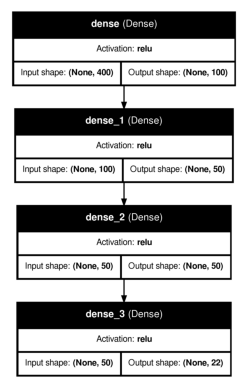

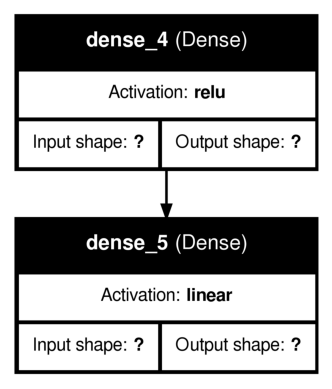

In [8]:
tf.keras.backend.clear_session()

tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

sizeLS = len(uv)*2
stacked_RDFencoder = tf.keras.Sequential([
    tf.keras.layers.Input((nRDFsteps,),name='inputLayer'),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(sizeLS, activation="relu"), #len of the dictionary. Why not? :-)
])

stacked_RDFdecoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(nRDFsteps),
    
])

stacked_edRDFmodel = tf.keras.Sequential([stacked_RDFencoder, stacked_RDFdecoder])

#t4pPC.centerTitle("Summary of the model")
stacked_RDFencoder.build()
stacked_RDFdecoder.build()
stacked_edRDFmodel.build()
stacked_edRDFmodel.summary()

#t4pPC.centerTitle("Plot models")
plotModel(stacked_RDFencoder, "StackedEncoder", MODELS_PATH=MODELS_PATH)
print()
plotModel(stacked_RDFdecoder, "StackedDecoder", MODELS_PATH=MODELS_PATH)

#### Training

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

metrics = ['mae']
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

vID.chrono_start()
stacked_edRDFmodel.compile(loss="mse",
                              optimizer="nadam",
                              metrics = metrics
                             )
history_edRDF = stacked_edRDFmodel.fit(x_train, x_train,
                                             epochs=50,
                                             validation_data=(x_valid, x_valid),
                                             batch_size=100,
                                             callbacks=[es]
                                            )
vID.chrono_show()

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0683 - mae: 0.1573 - val_loss: 0.0493 - val_mae: 0.1330
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0433 - mae: 0.1251 - val_loss: 0.0232 - val_mae: 0.0957
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0222 - mae: 0.0928 - val_loss: 0.0167 - val_mae: 0.0828
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0175 - mae: 0.0841 - val_loss: 0.0144 - val_mae: 0.0774
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0147 - mae: 0.0772 - val_loss: 0.0106 - val_mae: 0.0662
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0105 - mae: 0.0651 - val_loss: 0.0079 - val_mae: 0.0577
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0079 - mae: 0.0567 - val_loss: 0.0067 - val_mae: 0.0530
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0068 - mae: 0.0525 - val_loss: 0.0058 - val_mae: 0.0492
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0057 - mae: 0.0480 - val_loss

50
-0.0 0.1


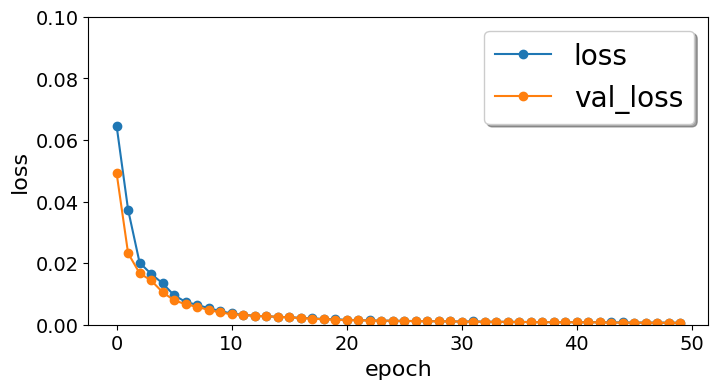

-0.0 0.1


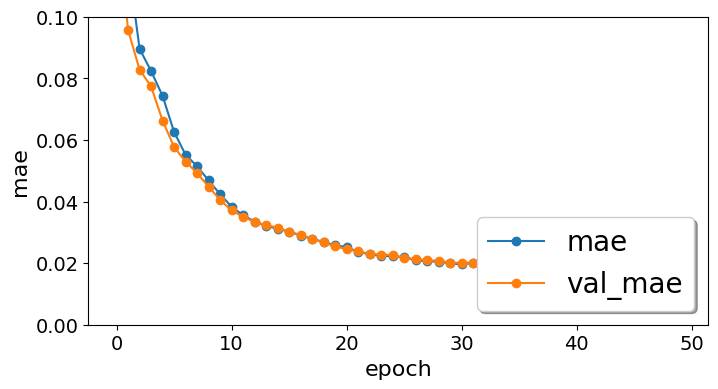

In [12]:
plotEpochs(history_edRDF,metrics)

### Visualization and other stuff

#### Encoding/decoding 

Shape of the NP = hcpsph2
Shape of the RDF input profile = (1, 400)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
(1, 400)


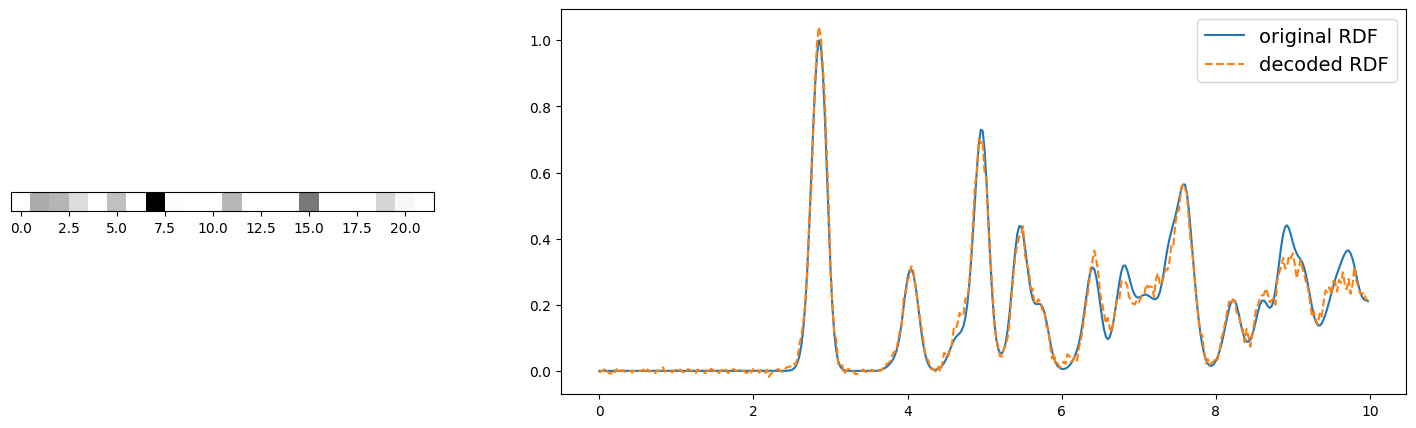

In [13]:
lsr, rimg = ShowRDFLatentSpaceRepresentation(stacked_RDFencoder,stacked_RDFdecoder, stacked_edRDFmodel, x_valid, y_valid, rStep, 5)

#### MAE for each subcategory

In [86]:
def MAE(rdf,stacked_ed):
    from sklearn.metrics import mean_absolute_error as MAE
    rdf = np.array(rdf)
    nSteps = len(rdf)
    rdf = rdf.reshape(1,nSteps)
    return MAE(rdf,stacked_ed(rdf))

for s in uv:
    dftmp = pd.DataFrame(data_valid[data_valid['Shape']==s].drop(columns=['Shape']).apply(MAE,stacked_ed=stacked_edRDFmodel,axis='columns'),columns=['MAE'])
    # display(dftmp)
    print(f"{s:10}. {dftmp['MAE'].mean():.3f}")

hcpsph2   . 0.019
fccCube   . 0.015
regfccOh  . 0.014
bccrDD    . 0.014
cubo      . 0.011
pbpy      . 0.016
fccdrDD   . 0.011
dd        . 0.020
fccTrOh   . 0.012
ico       . 0.020
bccCube   . 0.022


#### Visualization of the latent space

In [14]:
from sklearn.manifold import TSNE
x_valid_compressed = stacked_RDFencoder.predict(x_valid)
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
x_valid_2D = tsne.fit_transform(x_valid_compressed)
print(len(x_valid_2D))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
206


In [15]:
# print(y_valid)
# print(uv)
y_valid_asNumber = []
for s in y_valid:
    y_valid_asNumber.append(list(uv).index(s))
y_valid_asNumber = np.array(y_valid_asNumber)
# print(y_valid_asNumber)

206 206


x         y  color global shape            shape
0    0.628275  0.469364      0      hcpsph2  hcpsph2_000_003
1    0.613582  0.486646      0      hcpsph2  hcpsph2_000_006
2    0.626280  0.474719      0      hcpsph2  hcpsph2_000_019
3    0.424794  0.460019      0      hcpsph2  hcpsph2_010_017
4    0.435748  0.463851      0      hcpsph2  hcpsph2_010_020
..        ...       ...    ...          ...              ...
201  0.386167  0.096202     10      bccCube  bccCube_030_003
202  0.388843  0.098922     10      bccCube  bccCube_030_005
203  0.386544  0.094897     10      bccCube  bccCube_030_007
204  0.388319  0.098303     10      bccCube  bccCube_030_016
205  0.385720  0.096230     10      bccCube  bccCube_030_019

[206 rows x 5 columns]

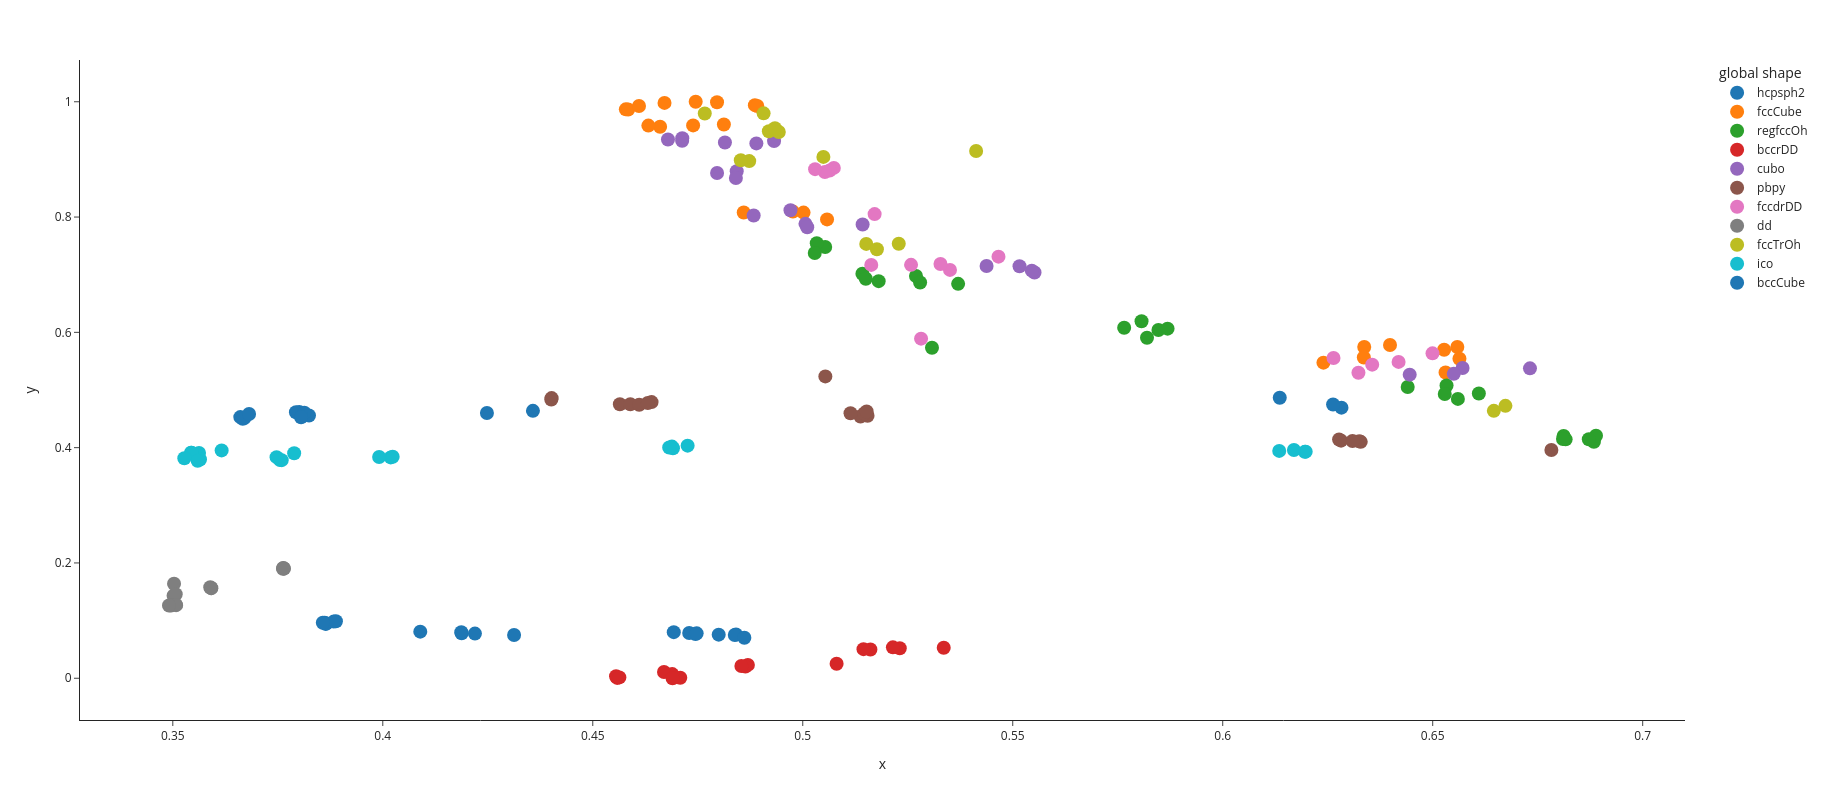

In [54]:
import matplotlib as mpl
from matplotlib.lines import Line2D
import plotly.express as px
cmap = plt.cm.tab10

t4pPC.centerTitle('TSNE scheme')
print(len(y_valid),len(x_valid_2D))
Z = x_valid_2D.copy()
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
cm = 1/2.54
df = pd.DataFrame()
df['x'] = Z[:, 0]
df['y'] = Z[:, 1]
df['color'] = y_valid_asNumber
df['global shape'] = y_valid
df['shape'] = data_valid.index
display(df)
# fig, ax = plt.subplots(figsize=(30*cm, 20*cm))
fig = px.scatter(df,x='x', y='y',color='global shape',hover_data='shape',
                 width=800, height=800,
                 template="simple_white",
                )
_ = fig.update_traces(marker_size=14)
fig.show()

# Useful links

[Autoencoder article on Wikipedia](https://en.wikipedia.org/wiki/Autoencoder)

[Hands-on machine learning with scikit-learn, keras and tensorflow (3rd edition, **2022**), Aurélien Géron, O'Reilly editions](https://github.com/ageron/handson-ml3)

[AI4Chemistry course](https://github.com/schwallergroup/ai4chem_course)

Some images were generated with [DALL·E](https://openai.com/dall-e-2)

In [ ]:
vID.end(cwd0)